In [223]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [224]:
flow = pd.read_csv("flow_train.csv")
# transition = pd.read_csv("transition_train.csv")

In [225]:
districts = sorted(flow.district_code.unique())
dates = sorted(flow.date_dt.unique())
cities = sorted(flow.city_code.unique())

dictdf = flow[[ 'district_code', 'city_code']].drop_duplicates()
d2c = dict(np.array(dictdf))
dictdf['district_code'] = dictdf['district_code'].apply(lambda x: districts.index(x))
dictdf['city_code'] = dictdf['city_code'].apply(lambda x: cities.index(x))
d2ci = dict(np.array(dictdf))
def dateStrlist(year,month, day, lenth):
    result = []
    for i in range(lenth):
        init_date = datetime.date(year, month, day)
        _date = init_date + datetime.timedelta(days=i)
        result.append(_date.strftime('%Y%m%d'))
    return result

In [226]:
trans = flow.copy()
trans['date_dt'] = trans['date_dt'].apply(lambda x: dates.index(x))
trans['district_code'] = trans['district_code'].apply(lambda x: districts.index(x))
trans['city_code'] = trans['city_code'].apply(lambda x: cities.index(x))

In [227]:
df = pd.DataFrame()
for d in range(len(districts)):
    dwell = np.log1p(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['dwell']))
    flow_in = np.log1p(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['flow_in']))
    flow_out = np.log1p(np.array(trans[trans.district_code == d].sort_values(by = 'date_dt')['flow_out']))
    df['dwell%d_b0'%d] = dwell
    df['flow_in%d_b0'%d] = flow_in
    df['flow_out%d_b0'%d] = flow_out
    for i in range(1, 30):
        df['dwell%d_b%d'%(d, i)]  = [*np.zeros(i), *dwell[:-i]]
        df['flow_in%d_b%d'%(d, i)]  = [*np.zeros(i), *flow_in[:-i]]
        df['flow_out%d_b%d'%(d, i)]  = [*np.zeros(i), *flow_out[:-i]]

In [228]:
for i in range(7):
    df["w%d"%i] = np.array(np.array(range(len(df)))%7 == i).astype(np.int8)
    
df["md"] = np.array(np.array(range(len(df)))%30)
df["mm"] = np.array(np.array(range(len(df)))//30)

In [230]:
def featureExtractor(fe, dist, col):
    nfe = pd.DataFrame()
    nfe[ "%s_b%d"%(col, 0)] = fe["%s%d_b%d"%(col, dist, 0)]
    
    #差分
    nfe["delta1"] = fe['%s%d_b%d'%(col, dist, 0)] - fe['%s%d_b%d'%(col, dist, 1)]
    nfe["delta2"] = fe['%s%d_b%d'%(col, dist, 0)] + fe['%s%d_b%d'%(col, dist, 2)] - 2*fe['%s%d_b%d'%(col, dist, 1)]
    nfe["delta3"] = fe['%s%d_b%d'%(col, dist, 0)] - 3*fe['%s%d_b%d'%(col, dist, 1)] + 3*fe['%s%d_b%d'%(col, dist, 2)] - fe['%s%d_b%d'%(col, dist, 3)]

    
    #统计特征
    for span in [3,7,15,30]:
        columns = ['%s%d_b%d'%(col, dist, j) for j in range(span)]
        nfe["max%d"%span] = np.array(fe[columns].max(axis = 1)).astype(np.float32)
        nfe["min%d"%span] =  np.array(fe[columns].min(axis = 1)).astype(np.float32)
        nfe["mean%d"%span] =  np.array(fe[columns].mean(axis = 1)).astype(np.float32)
        nfe["std%d"%span] =  np.array(fe[columns].std(axis = 1)).astype(np.float32)
    
    
    for i in range(7):
        nfe["w%d"%i] = fe["w%d"%i]
    
#     nfe['city_sum'] = 0
#     for i in range(98):
#         if d2ci[i] == d2ci[dist]:
#             nfe['city_sum'] = nfe['city_sum'] + fe["%s%d_b0"%(col, i)]
#         nfe["%s%d_b0"%(col, i)] =  np.array(fe["%s%d_b0"%(col, i)]).astype(np.float32)
        
    nfe['md'] = fe['md'].astype(np.int8)
    nfe['mm'] = fe['mm'].astype(np.int8)

    return nfe

# 分别建模预测

In [231]:
# 这里我们先拿前30天的数据 分别预测 1-15天后的数据。
# 后续可以尝试 今日预测1天后的，和2天谴预测2天后的，以此类推。多日模型进行融合。

for col in ['dwell', 'flow_in', 'flow_out']:
    dataDf = []
    for d in range(len(districts)):
        start_index = 30
        features = featureExtractor(df, d, col)
        labels = df["%s%d_b0"%(col,d)]
        for predict_span in range(1,16):
            label = labels[start_index + predict_span:]
            feature = features[start_index:-predict_span].copy()
            feature['y'] = label.tolist()
            
            #test feature
            test_x = features[-1:].copy()
            test_x['y'] = -1
            feature = feature.append(test_x)
            for i in range(2, 16):
                test_x = features[-i:-i+1].copy()
                test_x['y'] = -i
                feature = feature.append(test_x)
                
            #add district city info
            feature['district'] = np.int8(d)
            feature['city'] = d2ci[d]
            feature['span'] = np.int8(predict_span)
            dataDf.append(feature)
        print(end = ".")
    pd.concat(dataDf, axis = 0).to_csv("%s.csv"%col, index = None)
    print("\n", span)

..................................................................................................
 15
..................................................................................................
 15
..................................................................................................
 15


In [248]:
predicts = None
scores = []
for col in ['dwell', 'flow_in', 'flow_out']:
    tdf = pd.read_csv("%s.csv"%col)
    tdf['city'] = tdf['city'].astype("category")
    tdf['district'] = tdf['district'].astype("category")
    train = tdf[tdf.y > 0]
    feature = train.drop(['y'], axis = 1)
    label = train['y']
    skf = KFold(shuffle=True, random_state = 2018, n_splits= 5)
    splits = skf.split(feature, label)
    for train_index, eval_index in splits:
        train_x, eval_x, train_y, eval_y = train_test_split(feature, label, test_size = 0.2, random_state = 2018)
        train_x = feature[train_index]
        eval_x = feature[eval_index]
        train_y = feature[train_index]
        eval_y = feature[eval_index]                                                                                                                                   
    #     if col != 'dwell':
    #         train_x1 = train_x.copy()
    #         augRatio1 = (np.random.random(len(train_y)) - 0.5)/20 + 1
    #         augRatio2 = (np.random.random(len(train_y)) - 0.5)/50 + 1
    #         train_y1 = train_y*augRatio1
    #         train_y2 = train_y*augRatio2
    #         train_x = train_x.append(train_x1).append(train_x1)
    #         train_y = train_y.append(train_y1).append(train_y2)

        lgb_parms = {
            "boosting_type": "gbdt",
            "num_leaves": 127,
            "max_depth": -1,
            "learning_rate": 0.05,
            "n_estimators": 10000,
            "max_bin": 425,
            "subsample_for_bin": 20000,
            "objective": 'regression',
            # "metric": 'l1',
            "min_split_gain": 0,
            "min_child_weight": 0.001,
            "min_child_samples": 20,
            "subsample": 0.8,
            "subsample_freq": 1,
            "colsample_bytree": 0.8,
            "reg_alpha": 3,
            "reg_lambda": 5,
            "seed": 2018,
            "n_jobs": -1,
            "verbose": 1,
            "silent": False
        }

        lgbr = lgb.LGBMRegressor(**lgb_parms)
        lgbr.fit(train_x, train_y, eval_set = (eval_x, eval_y), early_stopping_rounds = 100, verbose  = True, eval_metric = 'rmse')
        pred = lgbr.predict(eval_x)
        print(col, np.sqrt(np.mean(np.square(pred - eval_y))), end = '\t')
        scores.append(np.mean(np.square(pred - eval_y)))
        cols = ['span', 'city', 'district']

        #预测测试集
        predictDfList = []
        for i in range(1, 16):
            test = tdf[tdf.y == -i]
            test_x = test.drop(['y'], axis = 1)
            test_x = test_x.sort_values(by = cols)
            pred = np.exp(lgbr.predict(test_x))-1
            predict = test_x[cols].copy()
            predict[col] = pred
            predict['span'] = predict['span'].apply(lambda d: d-i+1)
            predict = predict[predict.span > 0]
            predictDfList.append(predict);
        Coldf = pd.concat(predictDfList, axis = 0)
        Coldf = Coldf.groupby(['span','district'], as_index=False)[col].max()
        Coldf['city'] = Coldf['district'].apply(lambda x: d2ci[x])
        Coldf = Coldf.sort_values(by = cols)
        if predicts is None:
            predicts = Coldf.copy()
        else:
            predicts[col] = Coldf[col]
        
datelist = dateStrlist(2018,3, 2, 15)
predicts['date_dt'] = predicts['span'].apply(lambda x: datelist[x-1])
predicts['city'] = predicts['city'].apply(lambda x: cities[x])
predicts['district'] = predicts['district'].apply(lambda x: districts[x])
predicts[['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']].to_csv("lgb_predict.csv", index=None, header = None)
print(np.sqrt(np.mean(scores)))

[1]	valid_0's rmse: 0.85309
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.812395
[3]	valid_0's rmse: 0.773706
[4]	valid_0's rmse: 0.737031
[5]	valid_0's rmse: 0.702303
[6]	valid_0's rmse: 0.669327
[7]	valid_0's rmse: 0.638105
[8]	valid_0's rmse: 0.608602
[9]	valid_0's rmse: 0.580585
[10]	valid_0's rmse: 0.554042
[11]	valid_0's rmse: 0.528898
[12]	valid_0's rmse: 0.505102
[13]	valid_0's rmse: 0.482595
[14]	valid_0's rmse: 0.461375
[15]	valid_0's rmse: 0.441286
[16]	valid_0's rmse: 0.422379
[17]	valid_0's rmse: 0.404378
[18]	valid_0's rmse: 0.387433
[19]	valid_0's rmse: 0.371413
[20]	valid_0's rmse: 0.356332
[21]	valid_0's rmse: 0.342126
[22]	valid_0's rmse: 0.328679
[23]	valid_0's rmse: 0.316055
[24]	valid_0's rmse: 0.304175
[25]	valid_0's rmse: 0.29305
[26]	valid_0's rmse: 0.282666
[27]	valid_0's rmse: 0.272828
[28]	valid_0's rmse: 0.263643
[29]	valid_0's rmse: 0.254911
[30]	valid_0's rmse: 0.24685
[31]	valid_0's rmse: 0.239252
[32]	valid_0's rmse

[268]	valid_0's rmse: 0.113651
[269]	valid_0's rmse: 0.113637
[270]	valid_0's rmse: 0.113541
[271]	valid_0's rmse: 0.113521
[272]	valid_0's rmse: 0.11349
[273]	valid_0's rmse: 0.113478
[274]	valid_0's rmse: 0.113451
[275]	valid_0's rmse: 0.113411
[276]	valid_0's rmse: 0.113328
[277]	valid_0's rmse: 0.113227
[278]	valid_0's rmse: 0.113186
[279]	valid_0's rmse: 0.113121
[280]	valid_0's rmse: 0.113012
[281]	valid_0's rmse: 0.112994
[282]	valid_0's rmse: 0.112986
[283]	valid_0's rmse: 0.112969
[284]	valid_0's rmse: 0.11296
[285]	valid_0's rmse: 0.112938
[286]	valid_0's rmse: 0.112888
[287]	valid_0's rmse: 0.112837
[288]	valid_0's rmse: 0.112812
[289]	valid_0's rmse: 0.112803
[290]	valid_0's rmse: 0.112785
[291]	valid_0's rmse: 0.112753
[292]	valid_0's rmse: 0.112672
[293]	valid_0's rmse: 0.112626
[294]	valid_0's rmse: 0.112614
[295]	valid_0's rmse: 0.112606
[296]	valid_0's rmse: 0.112512
[297]	valid_0's rmse: 0.112475
[298]	valid_0's rmse: 0.112456
[299]	valid_0's rmse: 0.112405
[300]	vali

[536]	valid_0's rmse: 0.106874
[537]	valid_0's rmse: 0.106863
[538]	valid_0's rmse: 0.106836
[539]	valid_0's rmse: 0.106837
[540]	valid_0's rmse: 0.106814
[541]	valid_0's rmse: 0.106813
[542]	valid_0's rmse: 0.106789
[543]	valid_0's rmse: 0.106778
[544]	valid_0's rmse: 0.106764
[545]	valid_0's rmse: 0.106761
[546]	valid_0's rmse: 0.10676
[547]	valid_0's rmse: 0.106671
[548]	valid_0's rmse: 0.10667
[549]	valid_0's rmse: 0.106591
[550]	valid_0's rmse: 0.106589
[551]	valid_0's rmse: 0.106583
[552]	valid_0's rmse: 0.106576
[553]	valid_0's rmse: 0.106573
[554]	valid_0's rmse: 0.106557
[555]	valid_0's rmse: 0.106522
[556]	valid_0's rmse: 0.106523
[557]	valid_0's rmse: 0.106504
[558]	valid_0's rmse: 0.106436
[559]	valid_0's rmse: 0.106427
[560]	valid_0's rmse: 0.106424
[561]	valid_0's rmse: 0.106418
[562]	valid_0's rmse: 0.106403
[563]	valid_0's rmse: 0.106366
[564]	valid_0's rmse: 0.106363
[565]	valid_0's rmse: 0.106363
[566]	valid_0's rmse: 0.106362
[567]	valid_0's rmse: 0.106351
[568]	vali

[802]	valid_0's rmse: 0.103288
[803]	valid_0's rmse: 0.103279
[804]	valid_0's rmse: 0.103243
[805]	valid_0's rmse: 0.103243
[806]	valid_0's rmse: 0.103243
[807]	valid_0's rmse: 0.103239
[808]	valid_0's rmse: 0.103233
[809]	valid_0's rmse: 0.103235
[810]	valid_0's rmse: 0.103234
[811]	valid_0's rmse: 0.103223
[812]	valid_0's rmse: 0.103221
[813]	valid_0's rmse: 0.103207
[814]	valid_0's rmse: 0.103185
[815]	valid_0's rmse: 0.103182
[816]	valid_0's rmse: 0.103175
[817]	valid_0's rmse: 0.103158
[818]	valid_0's rmse: 0.103151
[819]	valid_0's rmse: 0.103104
[820]	valid_0's rmse: 0.1031
[821]	valid_0's rmse: 0.103079
[822]	valid_0's rmse: 0.103078
[823]	valid_0's rmse: 0.10306
[824]	valid_0's rmse: 0.103061
[825]	valid_0's rmse: 0.103054
[826]	valid_0's rmse: 0.103049
[827]	valid_0's rmse: 0.103045
[828]	valid_0's rmse: 0.103045
[829]	valid_0's rmse: 0.103045
[830]	valid_0's rmse: 0.103047
[831]	valid_0's rmse: 0.103044
[832]	valid_0's rmse: 0.103041
[833]	valid_0's rmse: 0.103031
[834]	valid

[1065]	valid_0's rmse: 0.101096
[1066]	valid_0's rmse: 0.101096
[1067]	valid_0's rmse: 0.101094
[1068]	valid_0's rmse: 0.101078
[1069]	valid_0's rmse: 0.101077
[1070]	valid_0's rmse: 0.101044
[1071]	valid_0's rmse: 0.101041
[1072]	valid_0's rmse: 0.101042
[1073]	valid_0's rmse: 0.101041
[1074]	valid_0's rmse: 0.101043
[1075]	valid_0's rmse: 0.101034
[1076]	valid_0's rmse: 0.101034
[1077]	valid_0's rmse: 0.101034
[1078]	valid_0's rmse: 0.101034
[1079]	valid_0's rmse: 0.101032
[1080]	valid_0's rmse: 0.101004
[1081]	valid_0's rmse: 0.100993
[1082]	valid_0's rmse: 0.100994
[1083]	valid_0's rmse: 0.10099
[1084]	valid_0's rmse: 0.100985
[1085]	valid_0's rmse: 0.100962
[1086]	valid_0's rmse: 0.10095
[1087]	valid_0's rmse: 0.100949
[1088]	valid_0's rmse: 0.10092
[1089]	valid_0's rmse: 0.100915
[1090]	valid_0's rmse: 0.100912
[1091]	valid_0's rmse: 0.100908
[1092]	valid_0's rmse: 0.100906
[1093]	valid_0's rmse: 0.100897
[1094]	valid_0's rmse: 0.10088
[1095]	valid_0's rmse: 0.100877
[1096]	valid

[1320]	valid_0's rmse: 0.0994665
[1321]	valid_0's rmse: 0.0994641
[1322]	valid_0's rmse: 0.0994643
[1323]	valid_0's rmse: 0.0994578
[1324]	valid_0's rmse: 0.0994586
[1325]	valid_0's rmse: 0.099458
[1326]	valid_0's rmse: 0.0994597
[1327]	valid_0's rmse: 0.0994585
[1328]	valid_0's rmse: 0.0994564
[1329]	valid_0's rmse: 0.0994575
[1330]	valid_0's rmse: 0.0994586
[1331]	valid_0's rmse: 0.099413
[1332]	valid_0's rmse: 0.0994135
[1333]	valid_0's rmse: 0.0994099
[1334]	valid_0's rmse: 0.0994087
[1335]	valid_0's rmse: 0.0994086
[1336]	valid_0's rmse: 0.0993942
[1337]	valid_0's rmse: 0.0993963
[1338]	valid_0's rmse: 0.0993937
[1339]	valid_0's rmse: 0.0993936
[1340]	valid_0's rmse: 0.0993941
[1341]	valid_0's rmse: 0.0993939
[1342]	valid_0's rmse: 0.0993937
[1343]	valid_0's rmse: 0.0993904
[1344]	valid_0's rmse: 0.0993755
[1345]	valid_0's rmse: 0.0993757
[1346]	valid_0's rmse: 0.0993559
[1347]	valid_0's rmse: 0.0993476
[1348]	valid_0's rmse: 0.0993459
[1349]	valid_0's rmse: 0.0993453
[1350]	valid

[1570]	valid_0's rmse: 0.0982927
[1571]	valid_0's rmse: 0.0982925
[1572]	valid_0's rmse: 0.0982891
[1573]	valid_0's rmse: 0.0982854
[1574]	valid_0's rmse: 0.0982847
[1575]	valid_0's rmse: 0.0982848
[1576]	valid_0's rmse: 0.0982833
[1577]	valid_0's rmse: 0.098284
[1578]	valid_0's rmse: 0.0982801
[1579]	valid_0's rmse: 0.0982802
[1580]	valid_0's rmse: 0.0982811
[1581]	valid_0's rmse: 0.0982808
[1582]	valid_0's rmse: 0.0982768
[1583]	valid_0's rmse: 0.0982058
[1584]	valid_0's rmse: 0.0982066
[1585]	valid_0's rmse: 0.0982039
[1586]	valid_0's rmse: 0.0981566
[1587]	valid_0's rmse: 0.098156
[1588]	valid_0's rmse: 0.0981516
[1589]	valid_0's rmse: 0.098145
[1590]	valid_0's rmse: 0.0981449
[1591]	valid_0's rmse: 0.098143
[1592]	valid_0's rmse: 0.0981438
[1593]	valid_0's rmse: 0.0981415
[1594]	valid_0's rmse: 0.0981377
[1595]	valid_0's rmse: 0.0981384
[1596]	valid_0's rmse: 0.0981106
[1597]	valid_0's rmse: 0.0980949
[1598]	valid_0's rmse: 0.0980952
[1599]	valid_0's rmse: 0.098095
[1600]	valid_0'

[1822]	valid_0's rmse: 0.0972623
[1823]	valid_0's rmse: 0.0972616
[1824]	valid_0's rmse: 0.0972616
[1825]	valid_0's rmse: 0.0972621
[1826]	valid_0's rmse: 0.0972625
[1827]	valid_0's rmse: 0.0972638
[1828]	valid_0's rmse: 0.0972652
[1829]	valid_0's rmse: 0.0972603
[1830]	valid_0's rmse: 0.0972612
[1831]	valid_0's rmse: 0.0972618
[1832]	valid_0's rmse: 0.09726
[1833]	valid_0's rmse: 0.0972479
[1834]	valid_0's rmse: 0.0972468
[1835]	valid_0's rmse: 0.0972467
[1836]	valid_0's rmse: 0.0972472
[1837]	valid_0's rmse: 0.0972485
[1838]	valid_0's rmse: 0.0972491
[1839]	valid_0's rmse: 0.0972474
[1840]	valid_0's rmse: 0.0972459
[1841]	valid_0's rmse: 0.0972436
[1842]	valid_0's rmse: 0.0972246
[1843]	valid_0's rmse: 0.097224
[1844]	valid_0's rmse: 0.0972225
[1845]	valid_0's rmse: 0.0972006
[1846]	valid_0's rmse: 0.0972016
[1847]	valid_0's rmse: 0.097202
[1848]	valid_0's rmse: 0.0972021
[1849]	valid_0's rmse: 0.097199
[1850]	valid_0's rmse: 0.0971998
[1851]	valid_0's rmse: 0.0971987
[1852]	valid_0'

[2074]	valid_0's rmse: 0.0961388
[2075]	valid_0's rmse: 0.0961364
[2076]	valid_0's rmse: 0.0961382
[2077]	valid_0's rmse: 0.0961352
[2078]	valid_0's rmse: 0.0961329
[2079]	valid_0's rmse: 0.0961305
[2080]	valid_0's rmse: 0.0961225
[2081]	valid_0's rmse: 0.0961245
[2082]	valid_0's rmse: 0.0961231
[2083]	valid_0's rmse: 0.0960957
[2084]	valid_0's rmse: 0.0960961
[2085]	valid_0's rmse: 0.0960948
[2086]	valid_0's rmse: 0.0960948
[2087]	valid_0's rmse: 0.0960957
[2088]	valid_0's rmse: 0.0960966
[2089]	valid_0's rmse: 0.0960971
[2090]	valid_0's rmse: 0.0960911
[2091]	valid_0's rmse: 0.096089
[2092]	valid_0's rmse: 0.0960889
[2093]	valid_0's rmse: 0.0960913
[2094]	valid_0's rmse: 0.0960918
[2095]	valid_0's rmse: 0.0960921
[2096]	valid_0's rmse: 0.0960928
[2097]	valid_0's rmse: 0.0960324
[2098]	valid_0's rmse: 0.0960299
[2099]	valid_0's rmse: 0.0960303
[2100]	valid_0's rmse: 0.0960289
[2101]	valid_0's rmse: 0.0960196
[2102]	valid_0's rmse: 0.0959893
[2103]	valid_0's rmse: 0.0959847
[2104]	vali

[2325]	valid_0's rmse: 0.0952352
[2326]	valid_0's rmse: 0.0952356
[2327]	valid_0's rmse: 0.0952354
[2328]	valid_0's rmse: 0.0952348
[2329]	valid_0's rmse: 0.0952354
[2330]	valid_0's rmse: 0.0952353
[2331]	valid_0's rmse: 0.0952366
[2332]	valid_0's rmse: 0.0952344
[2333]	valid_0's rmse: 0.0952113
[2334]	valid_0's rmse: 0.0951945
[2335]	valid_0's rmse: 0.0951943
[2336]	valid_0's rmse: 0.0951943
[2337]	valid_0's rmse: 0.0951943
[2338]	valid_0's rmse: 0.0951926
[2339]	valid_0's rmse: 0.0951925
[2340]	valid_0's rmse: 0.0951912
[2341]	valid_0's rmse: 0.0951801
[2342]	valid_0's rmse: 0.0951801
[2343]	valid_0's rmse: 0.0951797
[2344]	valid_0's rmse: 0.0951754
[2345]	valid_0's rmse: 0.0951739
[2346]	valid_0's rmse: 0.0951632
[2347]	valid_0's rmse: 0.0951629
[2348]	valid_0's rmse: 0.0951619
[2349]	valid_0's rmse: 0.0951611
[2350]	valid_0's rmse: 0.0951619
[2351]	valid_0's rmse: 0.0951623
[2352]	valid_0's rmse: 0.0951606
[2353]	valid_0's rmse: 0.0951608
[2354]	valid_0's rmse: 0.0951603
[2355]	val

[2575]	valid_0's rmse: 0.0942658
[2576]	valid_0's rmse: 0.0942651
[2577]	valid_0's rmse: 0.094265
[2578]	valid_0's rmse: 0.0942646
[2579]	valid_0's rmse: 0.094264
[2580]	valid_0's rmse: 0.0942616
[2581]	valid_0's rmse: 0.0942609
[2582]	valid_0's rmse: 0.0942396
[2583]	valid_0's rmse: 0.0942277
[2584]	valid_0's rmse: 0.0942276
[2585]	valid_0's rmse: 0.0942204
[2586]	valid_0's rmse: 0.0942204
[2587]	valid_0's rmse: 0.0942204
[2588]	valid_0's rmse: 0.0942195
[2589]	valid_0's rmse: 0.0942188
[2590]	valid_0's rmse: 0.0941942
[2591]	valid_0's rmse: 0.094195
[2592]	valid_0's rmse: 0.0941934
[2593]	valid_0's rmse: 0.0941836
[2594]	valid_0's rmse: 0.094184
[2595]	valid_0's rmse: 0.0941844
[2596]	valid_0's rmse: 0.0941844
[2597]	valid_0's rmse: 0.0941852
[2598]	valid_0's rmse: 0.0941863
[2599]	valid_0's rmse: 0.0941892
[2600]	valid_0's rmse: 0.094189
[2601]	valid_0's rmse: 0.0941879
[2602]	valid_0's rmse: 0.0941879
[2603]	valid_0's rmse: 0.0941858
[2604]	valid_0's rmse: 0.0941806
[2605]	valid_0'

[2825]	valid_0's rmse: 0.0932987
[2826]	valid_0's rmse: 0.0932991
[2827]	valid_0's rmse: 0.0932838
[2828]	valid_0's rmse: 0.0932842
[2829]	valid_0's rmse: 0.0932849
[2830]	valid_0's rmse: 0.0932858
[2831]	valid_0's rmse: 0.0932858
[2832]	valid_0's rmse: 0.0932872
[2833]	valid_0's rmse: 0.0932844
[2834]	valid_0's rmse: 0.0932832
[2835]	valid_0's rmse: 0.0932834
[2836]	valid_0's rmse: 0.093257
[2837]	valid_0's rmse: 0.0932404
[2838]	valid_0's rmse: 0.0932407
[2839]	valid_0's rmse: 0.0932401
[2840]	valid_0's rmse: 0.0932399
[2841]	valid_0's rmse: 0.0932395
[2842]	valid_0's rmse: 0.0932393
[2843]	valid_0's rmse: 0.0932397
[2844]	valid_0's rmse: 0.093239
[2845]	valid_0's rmse: 0.0932381
[2846]	valid_0's rmse: 0.0932379
[2847]	valid_0's rmse: 0.0932363
[2848]	valid_0's rmse: 0.0932375
[2849]	valid_0's rmse: 0.0932377
[2850]	valid_0's rmse: 0.0932378
[2851]	valid_0's rmse: 0.0932382
[2852]	valid_0's rmse: 0.0932387
[2853]	valid_0's rmse: 0.0932375
[2854]	valid_0's rmse: 0.0932377
[2855]	valid

[3076]	valid_0's rmse: 0.0926287
[3077]	valid_0's rmse: 0.092629
[3078]	valid_0's rmse: 0.0926279
[3079]	valid_0's rmse: 0.0926281
[3080]	valid_0's rmse: 0.0926276
[3081]	valid_0's rmse: 0.0926268
[3082]	valid_0's rmse: 0.0926236
[3083]	valid_0's rmse: 0.0926236
[3084]	valid_0's rmse: 0.0926229
[3085]	valid_0's rmse: 0.0926234
[3086]	valid_0's rmse: 0.0926237
[3087]	valid_0's rmse: 0.0926193
[3088]	valid_0's rmse: 0.092619
[3089]	valid_0's rmse: 0.0926199
[3090]	valid_0's rmse: 0.0926204
[3091]	valid_0's rmse: 0.0926193
[3092]	valid_0's rmse: 0.0926103
[3093]	valid_0's rmse: 0.0926077
[3094]	valid_0's rmse: 0.0926079
[3095]	valid_0's rmse: 0.0926082
[3096]	valid_0's rmse: 0.092609
[3097]	valid_0's rmse: 0.0926087
[3098]	valid_0's rmse: 0.0926093
[3099]	valid_0's rmse: 0.0926093
[3100]	valid_0's rmse: 0.0926094
[3101]	valid_0's rmse: 0.09261
[3102]	valid_0's rmse: 0.0926084
[3103]	valid_0's rmse: 0.0926097
[3104]	valid_0's rmse: 0.0925858
[3105]	valid_0's rmse: 0.0925832
[3106]	valid_0'

[3325]	valid_0's rmse: 0.0922241
[3326]	valid_0's rmse: 0.0922234
[3327]	valid_0's rmse: 0.0922238
[3328]	valid_0's rmse: 0.0922236
[3329]	valid_0's rmse: 0.0922205
[3330]	valid_0's rmse: 0.0922207
[3331]	valid_0's rmse: 0.0922197
[3332]	valid_0's rmse: 0.0922193
[3333]	valid_0's rmse: 0.0922154
[3334]	valid_0's rmse: 0.0922158
[3335]	valid_0's rmse: 0.0922165
[3336]	valid_0's rmse: 0.0922168
[3337]	valid_0's rmse: 0.0922159
[3338]	valid_0's rmse: 0.0922153
[3339]	valid_0's rmse: 0.0922153
[3340]	valid_0's rmse: 0.0922151
[3341]	valid_0's rmse: 0.0922148
[3342]	valid_0's rmse: 0.0922151
[3343]	valid_0's rmse: 0.0922152
[3344]	valid_0's rmse: 0.0922138
[3345]	valid_0's rmse: 0.0922139
[3346]	valid_0's rmse: 0.0922128
[3347]	valid_0's rmse: 0.0922118
[3348]	valid_0's rmse: 0.0922072
[3349]	valid_0's rmse: 0.0921944
[3350]	valid_0's rmse: 0.0921952
[3351]	valid_0's rmse: 0.0921952
[3352]	valid_0's rmse: 0.0921951
[3353]	valid_0's rmse: 0.0921949
[3354]	valid_0's rmse: 0.0921948
[3355]	val

[3576]	valid_0's rmse: 0.091664
[3577]	valid_0's rmse: 0.0916638
[3578]	valid_0's rmse: 0.0916636
[3579]	valid_0's rmse: 0.0916635
[3580]	valid_0's rmse: 0.0916628
[3581]	valid_0's rmse: 0.0916627
[3582]	valid_0's rmse: 0.0916598
[3583]	valid_0's rmse: 0.0916592
[3584]	valid_0's rmse: 0.0916589
[3585]	valid_0's rmse: 0.091659
[3586]	valid_0's rmse: 0.0916589
[3587]	valid_0's rmse: 0.0916578
[3588]	valid_0's rmse: 0.0916573
[3589]	valid_0's rmse: 0.091658
[3590]	valid_0's rmse: 0.0916585
[3591]	valid_0's rmse: 0.0916589
[3592]	valid_0's rmse: 0.0916555
[3593]	valid_0's rmse: 0.0916551
[3594]	valid_0's rmse: 0.0916552
[3595]	valid_0's rmse: 0.0916549
[3596]	valid_0's rmse: 0.0916548
[3597]	valid_0's rmse: 0.0916431
[3598]	valid_0's rmse: 0.0916431
[3599]	valid_0's rmse: 0.0916424
[3600]	valid_0's rmse: 0.0916395
[3601]	valid_0's rmse: 0.091639
[3602]	valid_0's rmse: 0.0916382
[3603]	valid_0's rmse: 0.0916384
[3604]	valid_0's rmse: 0.0916386
[3605]	valid_0's rmse: 0.0916379
[3606]	valid_0

[3826]	valid_0's rmse: 0.0912972
[3827]	valid_0's rmse: 0.0912972
[3828]	valid_0's rmse: 0.0912971
[3829]	valid_0's rmse: 0.0912973
[3830]	valid_0's rmse: 0.0912967
[3831]	valid_0's rmse: 0.0912967
[3832]	valid_0's rmse: 0.0912966
[3833]	valid_0's rmse: 0.0912949
[3834]	valid_0's rmse: 0.0912949
[3835]	valid_0's rmse: 0.0912935
[3836]	valid_0's rmse: 0.091277
[3837]	valid_0's rmse: 0.0912769
[3838]	valid_0's rmse: 0.0912776
[3839]	valid_0's rmse: 0.0912778
[3840]	valid_0's rmse: 0.0912687
[3841]	valid_0's rmse: 0.0912578
[3842]	valid_0's rmse: 0.0912578
[3843]	valid_0's rmse: 0.0912575
[3844]	valid_0's rmse: 0.0912575
[3845]	valid_0's rmse: 0.0912513
[3846]	valid_0's rmse: 0.0912497
[3847]	valid_0's rmse: 0.0912491
[3848]	valid_0's rmse: 0.0912478
[3849]	valid_0's rmse: 0.0912474
[3850]	valid_0's rmse: 0.091247
[3851]	valid_0's rmse: 0.0912469
[3852]	valid_0's rmse: 0.0912472
[3853]	valid_0's rmse: 0.0912491
[3854]	valid_0's rmse: 0.0912485
[3855]	valid_0's rmse: 0.091249
[3856]	valid_

[4077]	valid_0's rmse: 0.0909943
[4078]	valid_0's rmse: 0.0909951
[4079]	valid_0's rmse: 0.0909952
[4080]	valid_0's rmse: 0.0909942
[4081]	valid_0's rmse: 0.0909943
[4082]	valid_0's rmse: 0.0909938
[4083]	valid_0's rmse: 0.0909929
[4084]	valid_0's rmse: 0.0909928
[4085]	valid_0's rmse: 0.0909929
[4086]	valid_0's rmse: 0.090993
[4087]	valid_0's rmse: 0.0909928
[4088]	valid_0's rmse: 0.0909888
[4089]	valid_0's rmse: 0.0909812
[4090]	valid_0's rmse: 0.0909812
[4091]	valid_0's rmse: 0.0909778
[4092]	valid_0's rmse: 0.090977
[4093]	valid_0's rmse: 0.0909773
[4094]	valid_0's rmse: 0.0909776
[4095]	valid_0's rmse: 0.0909575
[4096]	valid_0's rmse: 0.0909575
[4097]	valid_0's rmse: 0.0909577
[4098]	valid_0's rmse: 0.0909557
[4099]	valid_0's rmse: 0.0909557
[4100]	valid_0's rmse: 0.0909561
[4101]	valid_0's rmse: 0.0909439
[4102]	valid_0's rmse: 0.0909422
[4103]	valid_0's rmse: 0.0909422
[4104]	valid_0's rmse: 0.0909347
[4105]	valid_0's rmse: 0.0909351
[4106]	valid_0's rmse: 0.0909348
[4107]	valid

[4327]	valid_0's rmse: 0.0905057
[4328]	valid_0's rmse: 0.0905061
[4329]	valid_0's rmse: 0.0905055
[4330]	valid_0's rmse: 0.0905052
[4331]	valid_0's rmse: 0.0905064
[4332]	valid_0's rmse: 0.0905069
[4333]	valid_0's rmse: 0.0905069
[4334]	valid_0's rmse: 0.0905071
[4335]	valid_0's rmse: 0.0905071
[4336]	valid_0's rmse: 0.0905064
[4337]	valid_0's rmse: 0.0905068
[4338]	valid_0's rmse: 0.0905065
[4339]	valid_0's rmse: 0.0905066
[4340]	valid_0's rmse: 0.0905056
[4341]	valid_0's rmse: 0.0905043
[4342]	valid_0's rmse: 0.0905037
[4343]	valid_0's rmse: 0.0905046
[4344]	valid_0's rmse: 0.0905058
[4345]	valid_0's rmse: 0.0905062
[4346]	valid_0's rmse: 0.0905046
[4347]	valid_0's rmse: 0.0905048
[4348]	valid_0's rmse: 0.0905051
[4349]	valid_0's rmse: 0.0905045
[4350]	valid_0's rmse: 0.0905049
[4351]	valid_0's rmse: 0.090505
[4352]	valid_0's rmse: 0.0905037
[4353]	valid_0's rmse: 0.0905039
[4354]	valid_0's rmse: 0.0905036
[4355]	valid_0's rmse: 0.0905033
[4356]	valid_0's rmse: 0.0905036
[4357]	vali

[4576]	valid_0's rmse: 0.0902062
[4577]	valid_0's rmse: 0.0902061
[4578]	valid_0's rmse: 0.090184
[4579]	valid_0's rmse: 0.0901838
[4580]	valid_0's rmse: 0.0901844
[4581]	valid_0's rmse: 0.0901845
[4582]	valid_0's rmse: 0.0901845
[4583]	valid_0's rmse: 0.0901695
[4584]	valid_0's rmse: 0.0901697
[4585]	valid_0's rmse: 0.0901693
[4586]	valid_0's rmse: 0.09017
[4587]	valid_0's rmse: 0.0901703
[4588]	valid_0's rmse: 0.0901698
[4589]	valid_0's rmse: 0.0901697
[4590]	valid_0's rmse: 0.0901709
[4591]	valid_0's rmse: 0.0901692
[4592]	valid_0's rmse: 0.0901686
[4593]	valid_0's rmse: 0.0901682
[4594]	valid_0's rmse: 0.0901683
[4595]	valid_0's rmse: 0.0901687
[4596]	valid_0's rmse: 0.090169
[4597]	valid_0's rmse: 0.0901685
[4598]	valid_0's rmse: 0.0901677
[4599]	valid_0's rmse: 0.0901678
[4600]	valid_0's rmse: 0.0901678
[4601]	valid_0's rmse: 0.0901672
[4602]	valid_0's rmse: 0.0901683
[4603]	valid_0's rmse: 0.0901632
[4604]	valid_0's rmse: 0.0901632
[4605]	valid_0's rmse: 0.090164
[4606]	valid_0'

[4828]	valid_0's rmse: 0.0898837
[4829]	valid_0's rmse: 0.0898836
[4830]	valid_0's rmse: 0.0898833
[4831]	valid_0's rmse: 0.0898838
[4832]	valid_0's rmse: 0.0898836
[4833]	valid_0's rmse: 0.0898839
[4834]	valid_0's rmse: 0.0898833
[4835]	valid_0's rmse: 0.0898835
[4836]	valid_0's rmse: 0.0898826
[4837]	valid_0's rmse: 0.0898823
[4838]	valid_0's rmse: 0.0898825
[4839]	valid_0's rmse: 0.0898824
[4840]	valid_0's rmse: 0.0898773
[4841]	valid_0's rmse: 0.089875
[4842]	valid_0's rmse: 0.0898751
[4843]	valid_0's rmse: 0.0898754
[4844]	valid_0's rmse: 0.0898763
[4845]	valid_0's rmse: 0.0898762
[4846]	valid_0's rmse: 0.0898763
[4847]	valid_0's rmse: 0.0898747
[4848]	valid_0's rmse: 0.0898746
[4849]	valid_0's rmse: 0.0898763
[4850]	valid_0's rmse: 0.0898764
[4851]	valid_0's rmse: 0.0898768
[4852]	valid_0's rmse: 0.0898568
[4853]	valid_0's rmse: 0.0898557
[4854]	valid_0's rmse: 0.0898542
[4855]	valid_0's rmse: 0.0898543
[4856]	valid_0's rmse: 0.0898558
[4857]	valid_0's rmse: 0.0898558
[4858]	vali

[5077]	valid_0's rmse: 0.0896428
[5078]	valid_0's rmse: 0.0896428
[5079]	valid_0's rmse: 0.0896404
[5080]	valid_0's rmse: 0.0896381
[5081]	valid_0's rmse: 0.0896388
[5082]	valid_0's rmse: 0.089639
[5083]	valid_0's rmse: 0.0896389
[5084]	valid_0's rmse: 0.0896352
[5085]	valid_0's rmse: 0.0896342
[5086]	valid_0's rmse: 0.0896342
[5087]	valid_0's rmse: 0.0896345
[5088]	valid_0's rmse: 0.0896346
[5089]	valid_0's rmse: 0.0896337
[5090]	valid_0's rmse: 0.0896306
[5091]	valid_0's rmse: 0.0896298
[5092]	valid_0's rmse: 0.0896302
[5093]	valid_0's rmse: 0.0896336
[5094]	valid_0's rmse: 0.0896337
[5095]	valid_0's rmse: 0.0896312
[5096]	valid_0's rmse: 0.0896313
[5097]	valid_0's rmse: 0.089632
[5098]	valid_0's rmse: 0.0896323
[5099]	valid_0's rmse: 0.089632
[5100]	valid_0's rmse: 0.0896319
[5101]	valid_0's rmse: 0.0896296
[5102]	valid_0's rmse: 0.0896301
[5103]	valid_0's rmse: 0.0896294
[5104]	valid_0's rmse: 0.0896289
[5105]	valid_0's rmse: 0.0896296
[5106]	valid_0's rmse: 0.0896241
[5107]	valid_

[5328]	valid_0's rmse: 0.0894741
[5329]	valid_0's rmse: 0.0894746
[5330]	valid_0's rmse: 0.0894742
[5331]	valid_0's rmse: 0.0894741
[5332]	valid_0's rmse: 0.0894739
[5333]	valid_0's rmse: 0.0894737
[5334]	valid_0's rmse: 0.0894739
[5335]	valid_0's rmse: 0.0894728
[5336]	valid_0's rmse: 0.0894733
[5337]	valid_0's rmse: 0.0894741
[5338]	valid_0's rmse: 0.089474
[5339]	valid_0's rmse: 0.0894719
[5340]	valid_0's rmse: 0.089472
[5341]	valid_0's rmse: 0.0894719
[5342]	valid_0's rmse: 0.0894546
[5343]	valid_0's rmse: 0.0894551
[5344]	valid_0's rmse: 0.0894552
[5345]	valid_0's rmse: 0.0894556
[5346]	valid_0's rmse: 0.0894557
[5347]	valid_0's rmse: 0.0894568
[5348]	valid_0's rmse: 0.0894567
[5349]	valid_0's rmse: 0.0894574
[5350]	valid_0's rmse: 0.0894578
[5351]	valid_0's rmse: 0.0894574
[5352]	valid_0's rmse: 0.0894571
[5353]	valid_0's rmse: 0.0894566
[5354]	valid_0's rmse: 0.0894564
[5355]	valid_0's rmse: 0.0894565
[5356]	valid_0's rmse: 0.0894566
[5357]	valid_0's rmse: 0.0894558
[5358]	valid

[5578]	valid_0's rmse: 0.0892146
[5579]	valid_0's rmse: 0.0892153
[5580]	valid_0's rmse: 0.0892156
[5581]	valid_0's rmse: 0.0892144
[5582]	valid_0's rmse: 0.0892139
[5583]	valid_0's rmse: 0.0892139
[5584]	valid_0's rmse: 0.0892138
[5585]	valid_0's rmse: 0.0892141
[5586]	valid_0's rmse: 0.0892142
[5587]	valid_0's rmse: 0.0892132
[5588]	valid_0's rmse: 0.0892133
[5589]	valid_0's rmse: 0.0892123
[5590]	valid_0's rmse: 0.0892124
[5591]	valid_0's rmse: 0.089212
[5592]	valid_0's rmse: 0.0892125
[5593]	valid_0's rmse: 0.0892126
[5594]	valid_0's rmse: 0.0892096
[5595]	valid_0's rmse: 0.0891921
[5596]	valid_0's rmse: 0.0891922
[5597]	valid_0's rmse: 0.089193
[5598]	valid_0's rmse: 0.0891927
[5599]	valid_0's rmse: 0.0891927
[5600]	valid_0's rmse: 0.0891924
[5601]	valid_0's rmse: 0.0891925
[5602]	valid_0's rmse: 0.0891931
[5603]	valid_0's rmse: 0.0891927
[5604]	valid_0's rmse: 0.0891926
[5605]	valid_0's rmse: 0.0891924
[5606]	valid_0's rmse: 0.0891923
[5607]	valid_0's rmse: 0.0891926
[5608]	valid

[5828]	valid_0's rmse: 0.0889199
[5829]	valid_0's rmse: 0.0889201
[5830]	valid_0's rmse: 0.0889203
[5831]	valid_0's rmse: 0.0889079
[5832]	valid_0's rmse: 0.0889079
[5833]	valid_0's rmse: 0.0889073
[5834]	valid_0's rmse: 0.0889075
[5835]	valid_0's rmse: 0.0889074
[5836]	valid_0's rmse: 0.0889078
[5837]	valid_0's rmse: 0.0889074
[5838]	valid_0's rmse: 0.0889083
[5839]	valid_0's rmse: 0.0889079
[5840]	valid_0's rmse: 0.0889079
[5841]	valid_0's rmse: 0.0889085
[5842]	valid_0's rmse: 0.0889089
[5843]	valid_0's rmse: 0.0889089
[5844]	valid_0's rmse: 0.0889092
[5845]	valid_0's rmse: 0.0889094
[5846]	valid_0's rmse: 0.08891
[5847]	valid_0's rmse: 0.0889099
[5848]	valid_0's rmse: 0.0889098
[5849]	valid_0's rmse: 0.0889008
[5850]	valid_0's rmse: 0.0889013
[5851]	valid_0's rmse: 0.0888952
[5852]	valid_0's rmse: 0.088895
[5853]	valid_0's rmse: 0.0888944
[5854]	valid_0's rmse: 0.0888945
[5855]	valid_0's rmse: 0.0888949
[5856]	valid_0's rmse: 0.088895
[5857]	valid_0's rmse: 0.0888953
[5858]	valid_0

[6078]	valid_0's rmse: 0.088554
[6079]	valid_0's rmse: 0.0885545
[6080]	valid_0's rmse: 0.088553
[6081]	valid_0's rmse: 0.0885531
[6082]	valid_0's rmse: 0.0885537
[6083]	valid_0's rmse: 0.0885534
[6084]	valid_0's rmse: 0.0885536
[6085]	valid_0's rmse: 0.0885535
[6086]	valid_0's rmse: 0.0885534
[6087]	valid_0's rmse: 0.0885534
[6088]	valid_0's rmse: 0.0885521
[6089]	valid_0's rmse: 0.0885522
[6090]	valid_0's rmse: 0.0885527
[6091]	valid_0's rmse: 0.0885533
[6092]	valid_0's rmse: 0.0885527
[6093]	valid_0's rmse: 0.0885517
[6094]	valid_0's rmse: 0.0885403
[6095]	valid_0's rmse: 0.0885404
[6096]	valid_0's rmse: 0.0885411
[6097]	valid_0's rmse: 0.0885405
[6098]	valid_0's rmse: 0.0885405
[6099]	valid_0's rmse: 0.0885419
[6100]	valid_0's rmse: 0.0885417
[6101]	valid_0's rmse: 0.0885423
[6102]	valid_0's rmse: 0.0885419
[6103]	valid_0's rmse: 0.0885417
[6104]	valid_0's rmse: 0.0885425
[6105]	valid_0's rmse: 0.0885428
[6106]	valid_0's rmse: 0.0885433
[6107]	valid_0's rmse: 0.0885431
[6108]	valid

[6329]	valid_0's rmse: 0.0883506
[6330]	valid_0's rmse: 0.0883507
[6331]	valid_0's rmse: 0.0883508
[6332]	valid_0's rmse: 0.0883429
[6333]	valid_0's rmse: 0.0883429
[6334]	valid_0's rmse: 0.0883426
[6335]	valid_0's rmse: 0.0883427
[6336]	valid_0's rmse: 0.0883429
[6337]	valid_0's rmse: 0.0883429
[6338]	valid_0's rmse: 0.0883428
[6339]	valid_0's rmse: 0.0883336
[6340]	valid_0's rmse: 0.0883341
[6341]	valid_0's rmse: 0.0883339
[6342]	valid_0's rmse: 0.088335
[6343]	valid_0's rmse: 0.0883318
[6344]	valid_0's rmse: 0.0883314
[6345]	valid_0's rmse: 0.0883311
[6346]	valid_0's rmse: 0.088325
[6347]	valid_0's rmse: 0.0883209
[6348]	valid_0's rmse: 0.0883208
[6349]	valid_0's rmse: 0.0883208
[6350]	valid_0's rmse: 0.0883203
[6351]	valid_0's rmse: 0.0883072
[6352]	valid_0's rmse: 0.0882955
[6353]	valid_0's rmse: 0.0882957
[6354]	valid_0's rmse: 0.0882966
[6355]	valid_0's rmse: 0.0882963
[6356]	valid_0's rmse: 0.0882966
[6357]	valid_0's rmse: 0.0882933
[6358]	valid_0's rmse: 0.088293
[6359]	valid_

[6579]	valid_0's rmse: 0.0881361
[6580]	valid_0's rmse: 0.0881357
[6581]	valid_0's rmse: 0.0881358
[6582]	valid_0's rmse: 0.0881353
[6583]	valid_0's rmse: 0.0881311
[6584]	valid_0's rmse: 0.0881306
[6585]	valid_0's rmse: 0.0881304
[6586]	valid_0's rmse: 0.0881306
[6587]	valid_0's rmse: 0.0881293
[6588]	valid_0's rmse: 0.0881194
[6589]	valid_0's rmse: 0.0881171
[6590]	valid_0's rmse: 0.0881169
[6591]	valid_0's rmse: 0.0881165
[6592]	valid_0's rmse: 0.0881165
[6593]	valid_0's rmse: 0.0881083
[6594]	valid_0's rmse: 0.0881087
[6595]	valid_0's rmse: 0.0881005
[6596]	valid_0's rmse: 0.0881007
[6597]	valid_0's rmse: 0.0880977
[6598]	valid_0's rmse: 0.0880974
[6599]	valid_0's rmse: 0.0880795
[6600]	valid_0's rmse: 0.0880798
[6601]	valid_0's rmse: 0.0880797
[6602]	valid_0's rmse: 0.0880796
[6603]	valid_0's rmse: 0.0880793
[6604]	valid_0's rmse: 0.0880808
[6605]	valid_0's rmse: 0.0880717
[6606]	valid_0's rmse: 0.0880664
[6607]	valid_0's rmse: 0.0880671
[6608]	valid_0's rmse: 0.0880667
[6609]	val

[6828]	valid_0's rmse: 0.0878913
[6829]	valid_0's rmse: 0.0878909
[6830]	valid_0's rmse: 0.0878905
[6831]	valid_0's rmse: 0.0878908
[6832]	valid_0's rmse: 0.0878908
[6833]	valid_0's rmse: 0.0878904
[6834]	valid_0's rmse: 0.0878906
[6835]	valid_0's rmse: 0.0878907
[6836]	valid_0's rmse: 0.0878903
[6837]	valid_0's rmse: 0.0878897
[6838]	valid_0's rmse: 0.08789
[6839]	valid_0's rmse: 0.0878904
[6840]	valid_0's rmse: 0.0878906
[6841]	valid_0's rmse: 0.0878902
[6842]	valid_0's rmse: 0.0878902
[6843]	valid_0's rmse: 0.0878897
[6844]	valid_0's rmse: 0.0878865
[6845]	valid_0's rmse: 0.0878864
[6846]	valid_0's rmse: 0.0878859
[6847]	valid_0's rmse: 0.0878862
[6848]	valid_0's rmse: 0.0878858
[6849]	valid_0's rmse: 0.087886
[6850]	valid_0's rmse: 0.0878865
[6851]	valid_0's rmse: 0.0878869
[6852]	valid_0's rmse: 0.0878863
[6853]	valid_0's rmse: 0.0878864
[6854]	valid_0's rmse: 0.0878861
[6855]	valid_0's rmse: 0.0878868
[6856]	valid_0's rmse: 0.0878821
[6857]	valid_0's rmse: 0.0878815
[6858]	valid_

[7080]	valid_0's rmse: 0.0877445
[7081]	valid_0's rmse: 0.0877444
[7082]	valid_0's rmse: 0.0877449
[7083]	valid_0's rmse: 0.0877453
[7084]	valid_0's rmse: 0.0877453
[7085]	valid_0's rmse: 0.0877457
[7086]	valid_0's rmse: 0.0877456
[7087]	valid_0's rmse: 0.0877455
[7088]	valid_0's rmse: 0.087746
[7089]	valid_0's rmse: 0.0877459
[7090]	valid_0's rmse: 0.0877458
[7091]	valid_0's rmse: 0.0877462
[7092]	valid_0's rmse: 0.0877463
[7093]	valid_0's rmse: 0.0877466
[7094]	valid_0's rmse: 0.0877468
[7095]	valid_0's rmse: 0.0877459
[7096]	valid_0's rmse: 0.0877405
[7097]	valid_0's rmse: 0.0877403
[7098]	valid_0's rmse: 0.0877367
[7099]	valid_0's rmse: 0.0877364
[7100]	valid_0's rmse: 0.0877367
[7101]	valid_0's rmse: 0.0877329
[7102]	valid_0's rmse: 0.0877332
[7103]	valid_0's rmse: 0.0877328
[7104]	valid_0's rmse: 0.0877332
[7105]	valid_0's rmse: 0.0877318
[7106]	valid_0's rmse: 0.0877314
[7107]	valid_0's rmse: 0.087731
[7108]	valid_0's rmse: 0.0877314
[7109]	valid_0's rmse: 0.0877325
[7110]	valid

[7329]	valid_0's rmse: 0.0875512
[7330]	valid_0's rmse: 0.0875509
[7331]	valid_0's rmse: 0.0875508
[7332]	valid_0's rmse: 0.0875506
[7333]	valid_0's rmse: 0.087551
[7334]	valid_0's rmse: 0.0875513
[7335]	valid_0's rmse: 0.0875513
[7336]	valid_0's rmse: 0.0875517
[7337]	valid_0's rmse: 0.0875518
[7338]	valid_0's rmse: 0.0875518
[7339]	valid_0's rmse: 0.0875514
[7340]	valid_0's rmse: 0.0875515
[7341]	valid_0's rmse: 0.0875525
[7342]	valid_0's rmse: 0.0875516
[7343]	valid_0's rmse: 0.0875522
[7344]	valid_0's rmse: 0.0875498
[7345]	valid_0's rmse: 0.0875495
[7346]	valid_0's rmse: 0.0875498
[7347]	valid_0's rmse: 0.0875502
[7348]	valid_0's rmse: 0.0875504
[7349]	valid_0's rmse: 0.0875499
[7350]	valid_0's rmse: 0.0875502
[7351]	valid_0's rmse: 0.0875501
[7352]	valid_0's rmse: 0.0875495
[7353]	valid_0's rmse: 0.0875501
[7354]	valid_0's rmse: 0.0875495
[7355]	valid_0's rmse: 0.0875493
[7356]	valid_0's rmse: 0.087547
[7357]	valid_0's rmse: 0.0875472
[7358]	valid_0's rmse: 0.0875467
[7359]	valid

[7580]	valid_0's rmse: 0.0873446
[7581]	valid_0's rmse: 0.0873439
[7582]	valid_0's rmse: 0.087344
[7583]	valid_0's rmse: 0.0873436
[7584]	valid_0's rmse: 0.0873438
[7585]	valid_0's rmse: 0.0873438
[7586]	valid_0's rmse: 0.0873434
[7587]	valid_0's rmse: 0.0873398
[7588]	valid_0's rmse: 0.0873399
[7589]	valid_0's rmse: 0.0873396
[7590]	valid_0's rmse: 0.0873391
[7591]	valid_0's rmse: 0.0873386
[7592]	valid_0's rmse: 0.0873391
[7593]	valid_0's rmse: 0.0873389
[7594]	valid_0's rmse: 0.0873364
[7595]	valid_0's rmse: 0.0873369
[7596]	valid_0's rmse: 0.0873359
[7597]	valid_0's rmse: 0.0873361
[7598]	valid_0's rmse: 0.0873356
[7599]	valid_0's rmse: 0.0873356
[7600]	valid_0's rmse: 0.087336
[7601]	valid_0's rmse: 0.0873364
[7602]	valid_0's rmse: 0.0873366
[7603]	valid_0's rmse: 0.0873364
[7604]	valid_0's rmse: 0.0873334
[7605]	valid_0's rmse: 0.0873332
[7606]	valid_0's rmse: 0.0873335
[7607]	valid_0's rmse: 0.0873333
[7608]	valid_0's rmse: 0.0873344
[7609]	valid_0's rmse: 0.0873344
[7610]	valid

[7829]	valid_0's rmse: 0.0871799
[7830]	valid_0's rmse: 0.0871797
[7831]	valid_0's rmse: 0.0871792
[7832]	valid_0's rmse: 0.0871791
[7833]	valid_0's rmse: 0.0871788
[7834]	valid_0's rmse: 0.0871785
[7835]	valid_0's rmse: 0.0871782
[7836]	valid_0's rmse: 0.0871785
[7837]	valid_0's rmse: 0.0871787
[7838]	valid_0's rmse: 0.0871789
[7839]	valid_0's rmse: 0.0871788
[7840]	valid_0's rmse: 0.0871751
[7841]	valid_0's rmse: 0.0871747
[7842]	valid_0's rmse: 0.0871743
[7843]	valid_0's rmse: 0.0871745
[7844]	valid_0's rmse: 0.0871751
[7845]	valid_0's rmse: 0.0871757
[7846]	valid_0's rmse: 0.0871762
[7847]	valid_0's rmse: 0.0871759
[7848]	valid_0's rmse: 0.0871759
[7849]	valid_0's rmse: 0.0871755
[7850]	valid_0's rmse: 0.0871747
[7851]	valid_0's rmse: 0.0871741
[7852]	valid_0's rmse: 0.0871736
[7853]	valid_0's rmse: 0.0871727
[7854]	valid_0's rmse: 0.0871716
[7855]	valid_0's rmse: 0.0871716
[7856]	valid_0's rmse: 0.0871719
[7857]	valid_0's rmse: 0.0871696
[7858]	valid_0's rmse: 0.0871696
[7859]	val

[8080]	valid_0's rmse: 0.0870012
[8081]	valid_0's rmse: 0.0870017
[8082]	valid_0's rmse: 0.0870014
[8083]	valid_0's rmse: 0.0870015
[8084]	valid_0's rmse: 0.0870017
[8085]	valid_0's rmse: 0.0870018
[8086]	valid_0's rmse: 0.0870018
[8087]	valid_0's rmse: 0.0870019
[8088]	valid_0's rmse: 0.087
[8089]	valid_0's rmse: 0.0869999
[8090]	valid_0's rmse: 0.0869999
[8091]	valid_0's rmse: 0.0869993
[8092]	valid_0's rmse: 0.0869996
[8093]	valid_0's rmse: 0.0869995
[8094]	valid_0's rmse: 0.0869995
[8095]	valid_0's rmse: 0.0870006
[8096]	valid_0's rmse: 0.0869999
[8097]	valid_0's rmse: 0.0869998
[8098]	valid_0's rmse: 0.0869999
[8099]	valid_0's rmse: 0.0870002
[8100]	valid_0's rmse: 0.0869995
[8101]	valid_0's rmse: 0.0870008
[8102]	valid_0's rmse: 0.087001
[8103]	valid_0's rmse: 0.0870011
[8104]	valid_0's rmse: 0.0870006
[8105]	valid_0's rmse: 0.0870007
[8106]	valid_0's rmse: 0.0870005
[8107]	valid_0's rmse: 0.0870006
[8108]	valid_0's rmse: 0.0870005
[8109]	valid_0's rmse: 0.0870003
[8110]	valid_0'

[8332]	valid_0's rmse: 0.0868718
[8333]	valid_0's rmse: 0.0868714
[8334]	valid_0's rmse: 0.0868708
[8335]	valid_0's rmse: 0.0868706
[8336]	valid_0's rmse: 0.086871
[8337]	valid_0's rmse: 0.0868706
[8338]	valid_0's rmse: 0.0868709
[8339]	valid_0's rmse: 0.0868705
[8340]	valid_0's rmse: 0.0868706
[8341]	valid_0's rmse: 0.0868703
[8342]	valid_0's rmse: 0.0868704
[8343]	valid_0's rmse: 0.086872
[8344]	valid_0's rmse: 0.0868719
[8345]	valid_0's rmse: 0.0868718
[8346]	valid_0's rmse: 0.086872
[8347]	valid_0's rmse: 0.0868711
[8348]	valid_0's rmse: 0.0868708
[8349]	valid_0's rmse: 0.0868711
[8350]	valid_0's rmse: 0.0868708
[8351]	valid_0's rmse: 0.0868704
[8352]	valid_0's rmse: 0.0868702
[8353]	valid_0's rmse: 0.0868674
[8354]	valid_0's rmse: 0.0868672
[8355]	valid_0's rmse: 0.0868678
[8356]	valid_0's rmse: 0.0868677
[8357]	valid_0's rmse: 0.0868673
[8358]	valid_0's rmse: 0.0868667
[8359]	valid_0's rmse: 0.0868663
[8360]	valid_0's rmse: 0.0868661
[8361]	valid_0's rmse: 0.086866
[8362]	valid_0

[8582]	valid_0's rmse: 0.0867173
[8583]	valid_0's rmse: 0.0867174
[8584]	valid_0's rmse: 0.0867176
[8585]	valid_0's rmse: 0.0867179
[8586]	valid_0's rmse: 0.0867176
[8587]	valid_0's rmse: 0.086718
[8588]	valid_0's rmse: 0.0867184
[8589]	valid_0's rmse: 0.0867186
[8590]	valid_0's rmse: 0.0867183
[8591]	valid_0's rmse: 0.0867178
[8592]	valid_0's rmse: 0.0867175
[8593]	valid_0's rmse: 0.0867128
[8594]	valid_0's rmse: 0.0867127
[8595]	valid_0's rmse: 0.0867133
[8596]	valid_0's rmse: 0.0867127
[8597]	valid_0's rmse: 0.0867123
[8598]	valid_0's rmse: 0.0867124
[8599]	valid_0's rmse: 0.0867129
[8600]	valid_0's rmse: 0.0867132
[8601]	valid_0's rmse: 0.0867131
[8602]	valid_0's rmse: 0.0867131
[8603]	valid_0's rmse: 0.0867132
[8604]	valid_0's rmse: 0.0867129
[8605]	valid_0's rmse: 0.0867132
[8606]	valid_0's rmse: 0.086713
[8607]	valid_0's rmse: 0.0867124
[8608]	valid_0's rmse: 0.0867126
[8609]	valid_0's rmse: 0.0867129
[8610]	valid_0's rmse: 0.0867126
[8611]	valid_0's rmse: 0.0867128
[8612]	valid

[8833]	valid_0's rmse: 0.0865869
[8834]	valid_0's rmse: 0.086587
[8835]	valid_0's rmse: 0.0865814
[8836]	valid_0's rmse: 0.086583
[8837]	valid_0's rmse: 0.0865832
[8838]	valid_0's rmse: 0.0865828
[8839]	valid_0's rmse: 0.0865825
[8840]	valid_0's rmse: 0.0865777
[8841]	valid_0's rmse: 0.0865774
[8842]	valid_0's rmse: 0.0865776
[8843]	valid_0's rmse: 0.0865777
[8844]	valid_0's rmse: 0.086578
[8845]	valid_0's rmse: 0.0865776
[8846]	valid_0's rmse: 0.0865682
[8847]	valid_0's rmse: 0.0865685
[8848]	valid_0's rmse: 0.0865648
[8849]	valid_0's rmse: 0.0865639
[8850]	valid_0's rmse: 0.0865641
[8851]	valid_0's rmse: 0.0865641
[8852]	valid_0's rmse: 0.0865644
[8853]	valid_0's rmse: 0.0865646
[8854]	valid_0's rmse: 0.0865645
[8855]	valid_0's rmse: 0.0865616
[8856]	valid_0's rmse: 0.0865614
[8857]	valid_0's rmse: 0.0865632
[8858]	valid_0's rmse: 0.0865634
[8859]	valid_0's rmse: 0.0865634
[8860]	valid_0's rmse: 0.0865633
[8861]	valid_0's rmse: 0.0865619
[8862]	valid_0's rmse: 0.0865625
[8863]	valid_

[9082]	valid_0's rmse: 0.0864412
[9083]	valid_0's rmse: 0.0864397
[9084]	valid_0's rmse: 0.0864393
[9085]	valid_0's rmse: 0.0864398
[9086]	valid_0's rmse: 0.0864397
[9087]	valid_0's rmse: 0.0864397
[9088]	valid_0's rmse: 0.0864396
[9089]	valid_0's rmse: 0.0864394
[9090]	valid_0's rmse: 0.0864355
[9091]	valid_0's rmse: 0.0864358
[9092]	valid_0's rmse: 0.0864359
[9093]	valid_0's rmse: 0.0864363
[9094]	valid_0's rmse: 0.0864306
[9095]	valid_0's rmse: 0.0864309
[9096]	valid_0's rmse: 0.0864293
[9097]	valid_0's rmse: 0.0864294
[9098]	valid_0's rmse: 0.0864289
[9099]	valid_0's rmse: 0.0864274
[9100]	valid_0's rmse: 0.0864273
[9101]	valid_0's rmse: 0.086422
[9102]	valid_0's rmse: 0.0864211
[9103]	valid_0's rmse: 0.0864211
[9104]	valid_0's rmse: 0.0864213
[9105]	valid_0's rmse: 0.086419
[9106]	valid_0's rmse: 0.0864184
[9107]	valid_0's rmse: 0.0864181
[9108]	valid_0's rmse: 0.0864109
[9109]	valid_0's rmse: 0.086411
[9110]	valid_0's rmse: 0.0864037
[9111]	valid_0's rmse: 0.0864034
[9112]	valid_

[9334]	valid_0's rmse: 0.0863104
[9335]	valid_0's rmse: 0.0863105
[9336]	valid_0's rmse: 0.0863101
[9337]	valid_0's rmse: 0.08631
[9338]	valid_0's rmse: 0.0863101
[9339]	valid_0's rmse: 0.0863108
[9340]	valid_0's rmse: 0.0863106
[9341]	valid_0's rmse: 0.086311
[9342]	valid_0's rmse: 0.0863109
[9343]	valid_0's rmse: 0.0863111
[9344]	valid_0's rmse: 0.0863102
[9345]	valid_0's rmse: 0.0863099
[9346]	valid_0's rmse: 0.08631
[9347]	valid_0's rmse: 0.0863101
[9348]	valid_0's rmse: 0.0863102
[9349]	valid_0's rmse: 0.0863103
[9350]	valid_0's rmse: 0.0863107
[9351]	valid_0's rmse: 0.0863111
[9352]	valid_0's rmse: 0.0863112
[9353]	valid_0's rmse: 0.0863112
[9354]	valid_0's rmse: 0.0863104
[9355]	valid_0's rmse: 0.0863096
[9356]	valid_0's rmse: 0.0863103
[9357]	valid_0's rmse: 0.0863097
[9358]	valid_0's rmse: 0.0863096
[9359]	valid_0's rmse: 0.0863097
[9360]	valid_0's rmse: 0.0863056
[9361]	valid_0's rmse: 0.0863057
[9362]	valid_0's rmse: 0.086306
[9363]	valid_0's rmse: 0.0863059
[9364]	valid_0's

[9584]	valid_0's rmse: 0.0861864
[9585]	valid_0's rmse: 0.0861862
[9586]	valid_0's rmse: 0.0861864
[9587]	valid_0's rmse: 0.0861867
[9588]	valid_0's rmse: 0.0861838
[9589]	valid_0's rmse: 0.0861844
[9590]	valid_0's rmse: 0.0861851
[9591]	valid_0's rmse: 0.0861848
[9592]	valid_0's rmse: 0.0861847
[9593]	valid_0's rmse: 0.0861845
[9594]	valid_0's rmse: 0.0861848
[9595]	valid_0's rmse: 0.0861845
[9596]	valid_0's rmse: 0.0861838
[9597]	valid_0's rmse: 0.0861832
[9598]	valid_0's rmse: 0.0861846
[9599]	valid_0's rmse: 0.0861845
[9600]	valid_0's rmse: 0.0861851
[9601]	valid_0's rmse: 0.086185
[9602]	valid_0's rmse: 0.0861852
[9603]	valid_0's rmse: 0.0861858
[9604]	valid_0's rmse: 0.0861861
[9605]	valid_0's rmse: 0.0861854
[9606]	valid_0's rmse: 0.0861856
[9607]	valid_0's rmse: 0.0861857
[9608]	valid_0's rmse: 0.0861864
[9609]	valid_0's rmse: 0.0861863
[9610]	valid_0's rmse: 0.0861867
[9611]	valid_0's rmse: 0.0861868
[9612]	valid_0's rmse: 0.0861865
[9613]	valid_0's rmse: 0.0861864
[9614]	vali

[9836]	valid_0's rmse: 0.0860958
[9837]	valid_0's rmse: 0.0860953
[9838]	valid_0's rmse: 0.0860947
[9839]	valid_0's rmse: 0.0860951
[9840]	valid_0's rmse: 0.0860945
[9841]	valid_0's rmse: 0.086092
[9842]	valid_0's rmse: 0.0860918
[9843]	valid_0's rmse: 0.0860912
[9844]	valid_0's rmse: 0.0860912
[9845]	valid_0's rmse: 0.0860909
[9846]	valid_0's rmse: 0.0860909
[9847]	valid_0's rmse: 0.0860912
[9848]	valid_0's rmse: 0.086091
[9849]	valid_0's rmse: 0.0860882
[9850]	valid_0's rmse: 0.086087
[9851]	valid_0's rmse: 0.0860873
[9852]	valid_0's rmse: 0.0860866
[9853]	valid_0's rmse: 0.0860866
[9854]	valid_0's rmse: 0.0860863
[9855]	valid_0's rmse: 0.0860863
[9856]	valid_0's rmse: 0.0860868
[9857]	valid_0's rmse: 0.0860847
[9858]	valid_0's rmse: 0.0860846
[9859]	valid_0's rmse: 0.0860846
[9860]	valid_0's rmse: 0.0860847
[9861]	valid_0's rmse: 0.0860847
[9862]	valid_0's rmse: 0.0860849
[9863]	valid_0's rmse: 0.0860846
[9864]	valid_0's rmse: 0.0860838
[9865]	valid_0's rmse: 0.0860837
[9866]	valid_

[89]	valid_0's rmse: 0.175252
[90]	valid_0's rmse: 0.174964
[91]	valid_0's rmse: 0.174649
[92]	valid_0's rmse: 0.174201
[93]	valid_0's rmse: 0.173932
[94]	valid_0's rmse: 0.173417
[95]	valid_0's rmse: 0.173121
[96]	valid_0's rmse: 0.172699
[97]	valid_0's rmse: 0.172525
[98]	valid_0's rmse: 0.172297
[99]	valid_0's rmse: 0.172023
[100]	valid_0's rmse: 0.171791
[101]	valid_0's rmse: 0.171614
[102]	valid_0's rmse: 0.17144
[103]	valid_0's rmse: 0.171285
[104]	valid_0's rmse: 0.170812
[105]	valid_0's rmse: 0.170658
[106]	valid_0's rmse: 0.170223
[107]	valid_0's rmse: 0.170082
[108]	valid_0's rmse: 0.169936
[109]	valid_0's rmse: 0.16924
[110]	valid_0's rmse: 0.168977
[111]	valid_0's rmse: 0.168833
[112]	valid_0's rmse: 0.168165
[113]	valid_0's rmse: 0.167962
[114]	valid_0's rmse: 0.16751
[115]	valid_0's rmse: 0.167339
[116]	valid_0's rmse: 0.16709
[117]	valid_0's rmse: 0.166879
[118]	valid_0's rmse: 0.166727
[119]	valid_0's rmse: 0.166578
[120]	valid_0's rmse: 0.166397
[121]	valid_0's rmse: 0

[356]	valid_0's rmse: 0.145315
[357]	valid_0's rmse: 0.145275
[358]	valid_0's rmse: 0.145252
[359]	valid_0's rmse: 0.145201
[360]	valid_0's rmse: 0.1452
[361]	valid_0's rmse: 0.145162
[362]	valid_0's rmse: 0.145125
[363]	valid_0's rmse: 0.145117
[364]	valid_0's rmse: 0.145113
[365]	valid_0's rmse: 0.145106
[366]	valid_0's rmse: 0.145079
[367]	valid_0's rmse: 0.145056
[368]	valid_0's rmse: 0.145016
[369]	valid_0's rmse: 0.145009
[370]	valid_0's rmse: 0.144977
[371]	valid_0's rmse: 0.144967
[372]	valid_0's rmse: 0.144956
[373]	valid_0's rmse: 0.144945
[374]	valid_0's rmse: 0.144934
[375]	valid_0's rmse: 0.144896
[376]	valid_0's rmse: 0.144851
[377]	valid_0's rmse: 0.144813
[378]	valid_0's rmse: 0.144792
[379]	valid_0's rmse: 0.144755
[380]	valid_0's rmse: 0.14472
[381]	valid_0's rmse: 0.144702
[382]	valid_0's rmse: 0.144697
[383]	valid_0's rmse: 0.144662
[384]	valid_0's rmse: 0.144625
[385]	valid_0's rmse: 0.144614
[386]	valid_0's rmse: 0.144553
[387]	valid_0's rmse: 0.144543
[388]	valid

[622]	valid_0's rmse: 0.139488
[623]	valid_0's rmse: 0.139468
[624]	valid_0's rmse: 0.139465
[625]	valid_0's rmse: 0.139451
[626]	valid_0's rmse: 0.139451
[627]	valid_0's rmse: 0.139451
[628]	valid_0's rmse: 0.139447
[629]	valid_0's rmse: 0.139443
[630]	valid_0's rmse: 0.139439
[631]	valid_0's rmse: 0.139433
[632]	valid_0's rmse: 0.139425
[633]	valid_0's rmse: 0.139418
[634]	valid_0's rmse: 0.139407
[635]	valid_0's rmse: 0.139388
[636]	valid_0's rmse: 0.139381
[637]	valid_0's rmse: 0.139376
[638]	valid_0's rmse: 0.139374
[639]	valid_0's rmse: 0.139366
[640]	valid_0's rmse: 0.139355
[641]	valid_0's rmse: 0.139358
[642]	valid_0's rmse: 0.139362
[643]	valid_0's rmse: 0.139356
[644]	valid_0's rmse: 0.139346
[645]	valid_0's rmse: 0.139336
[646]	valid_0's rmse: 0.139329
[647]	valid_0's rmse: 0.139305
[648]	valid_0's rmse: 0.139291
[649]	valid_0's rmse: 0.139293
[650]	valid_0's rmse: 0.139282
[651]	valid_0's rmse: 0.139275
[652]	valid_0's rmse: 0.139277
[653]	valid_0's rmse: 0.139235
[654]	va

[889]	valid_0's rmse: 0.136355
[890]	valid_0's rmse: 0.136325
[891]	valid_0's rmse: 0.136331
[892]	valid_0's rmse: 0.136314
[893]	valid_0's rmse: 0.136316
[894]	valid_0's rmse: 0.136313
[895]	valid_0's rmse: 0.13631
[896]	valid_0's rmse: 0.136305
[897]	valid_0's rmse: 0.136298
[898]	valid_0's rmse: 0.136226
[899]	valid_0's rmse: 0.136206
[900]	valid_0's rmse: 0.136062
[901]	valid_0's rmse: 0.13606
[902]	valid_0's rmse: 0.136053
[903]	valid_0's rmse: 0.136053
[904]	valid_0's rmse: 0.136053
[905]	valid_0's rmse: 0.136038
[906]	valid_0's rmse: 0.136011
[907]	valid_0's rmse: 0.135975
[908]	valid_0's rmse: 0.135962
[909]	valid_0's rmse: 0.135954
[910]	valid_0's rmse: 0.135951
[911]	valid_0's rmse: 0.135827
[912]	valid_0's rmse: 0.13582
[913]	valid_0's rmse: 0.135811
[914]	valid_0's rmse: 0.135805
[915]	valid_0's rmse: 0.135807
[916]	valid_0's rmse: 0.135781
[917]	valid_0's rmse: 0.135783
[918]	valid_0's rmse: 0.135785
[919]	valid_0's rmse: 0.135778
[920]	valid_0's rmse: 0.13577
[921]	valid_

[1151]	valid_0's rmse: 0.133397
[1152]	valid_0's rmse: 0.133394
[1153]	valid_0's rmse: 0.133395
[1154]	valid_0's rmse: 0.133395
[1155]	valid_0's rmse: 0.133389
[1156]	valid_0's rmse: 0.133379
[1157]	valid_0's rmse: 0.133376
[1158]	valid_0's rmse: 0.133364
[1159]	valid_0's rmse: 0.133362
[1160]	valid_0's rmse: 0.133345
[1161]	valid_0's rmse: 0.133332
[1162]	valid_0's rmse: 0.133328
[1163]	valid_0's rmse: 0.133325
[1164]	valid_0's rmse: 0.133322
[1165]	valid_0's rmse: 0.133323
[1166]	valid_0's rmse: 0.133317
[1167]	valid_0's rmse: 0.133309
[1168]	valid_0's rmse: 0.133297
[1169]	valid_0's rmse: 0.133289
[1170]	valid_0's rmse: 0.133285
[1171]	valid_0's rmse: 0.133281
[1172]	valid_0's rmse: 0.133266
[1173]	valid_0's rmse: 0.133268
[1174]	valid_0's rmse: 0.133263
[1175]	valid_0's rmse: 0.13326
[1176]	valid_0's rmse: 0.133256
[1177]	valid_0's rmse: 0.133257
[1178]	valid_0's rmse: 0.133257
[1179]	valid_0's rmse: 0.13326
[1180]	valid_0's rmse: 0.133255
[1181]	valid_0's rmse: 0.133255
[1182]	val

[1409]	valid_0's rmse: 0.131628
[1410]	valid_0's rmse: 0.131624
[1411]	valid_0's rmse: 0.131629
[1412]	valid_0's rmse: 0.13163
[1413]	valid_0's rmse: 0.131632
[1414]	valid_0's rmse: 0.131627
[1415]	valid_0's rmse: 0.131625
[1416]	valid_0's rmse: 0.13163
[1417]	valid_0's rmse: 0.131613
[1418]	valid_0's rmse: 0.131614
[1419]	valid_0's rmse: 0.131601
[1420]	valid_0's rmse: 0.131596
[1421]	valid_0's rmse: 0.1316
[1422]	valid_0's rmse: 0.131584
[1423]	valid_0's rmse: 0.131572
[1424]	valid_0's rmse: 0.131546
[1425]	valid_0's rmse: 0.131544
[1426]	valid_0's rmse: 0.131541
[1427]	valid_0's rmse: 0.131478
[1428]	valid_0's rmse: 0.131479
[1429]	valid_0's rmse: 0.131481
[1430]	valid_0's rmse: 0.131482
[1431]	valid_0's rmse: 0.131482
[1432]	valid_0's rmse: 0.131483
[1433]	valid_0's rmse: 0.131482
[1434]	valid_0's rmse: 0.131482
[1435]	valid_0's rmse: 0.131478
[1436]	valid_0's rmse: 0.131457
[1437]	valid_0's rmse: 0.131452
[1438]	valid_0's rmse: 0.131372
[1439]	valid_0's rmse: 0.131372
[1440]	valid

[1669]	valid_0's rmse: 0.129947
[1670]	valid_0's rmse: 0.129925
[1671]	valid_0's rmse: 0.129925
[1672]	valid_0's rmse: 0.129927
[1673]	valid_0's rmse: 0.129921
[1674]	valid_0's rmse: 0.129914
[1675]	valid_0's rmse: 0.129913
[1676]	valid_0's rmse: 0.129907
[1677]	valid_0's rmse: 0.129904
[1678]	valid_0's rmse: 0.129904
[1679]	valid_0's rmse: 0.129904
[1680]	valid_0's rmse: 0.129902
[1681]	valid_0's rmse: 0.129905
[1682]	valid_0's rmse: 0.129897
[1683]	valid_0's rmse: 0.129898
[1684]	valid_0's rmse: 0.129901
[1685]	valid_0's rmse: 0.129893
[1686]	valid_0's rmse: 0.129895
[1687]	valid_0's rmse: 0.129892
[1688]	valid_0's rmse: 0.129837
[1689]	valid_0's rmse: 0.129831
[1690]	valid_0's rmse: 0.129834
[1691]	valid_0's rmse: 0.129839
[1692]	valid_0's rmse: 0.12984
[1693]	valid_0's rmse: 0.129753
[1694]	valid_0's rmse: 0.129757
[1695]	valid_0's rmse: 0.129751
[1696]	valid_0's rmse: 0.129739
[1697]	valid_0's rmse: 0.12973
[1698]	valid_0's rmse: 0.129706
[1699]	valid_0's rmse: 0.129704
[1700]	val

[1927]	valid_0's rmse: 0.128682
[1928]	valid_0's rmse: 0.128681
[1929]	valid_0's rmse: 0.128675
[1930]	valid_0's rmse: 0.128653
[1931]	valid_0's rmse: 0.12865
[1932]	valid_0's rmse: 0.128649
[1933]	valid_0's rmse: 0.128648
[1934]	valid_0's rmse: 0.128645
[1935]	valid_0's rmse: 0.128643
[1936]	valid_0's rmse: 0.128632
[1937]	valid_0's rmse: 0.128636
[1938]	valid_0's rmse: 0.128619
[1939]	valid_0's rmse: 0.128618
[1940]	valid_0's rmse: 0.128621
[1941]	valid_0's rmse: 0.128617
[1942]	valid_0's rmse: 0.128614
[1943]	valid_0's rmse: 0.128612
[1944]	valid_0's rmse: 0.128613
[1945]	valid_0's rmse: 0.128614
[1946]	valid_0's rmse: 0.128616
[1947]	valid_0's rmse: 0.128616
[1948]	valid_0's rmse: 0.128617
[1949]	valid_0's rmse: 0.12862
[1950]	valid_0's rmse: 0.12862
[1951]	valid_0's rmse: 0.128619
[1952]	valid_0's rmse: 0.128616
[1953]	valid_0's rmse: 0.128578
[1954]	valid_0's rmse: 0.128576
[1955]	valid_0's rmse: 0.128573
[1956]	valid_0's rmse: 0.128575
[1957]	valid_0's rmse: 0.128574
[1958]	vali

[2185]	valid_0's rmse: 0.127235
[2186]	valid_0's rmse: 0.127232
[2187]	valid_0's rmse: 0.127231
[2188]	valid_0's rmse: 0.127192
[2189]	valid_0's rmse: 0.127193
[2190]	valid_0's rmse: 0.127194
[2191]	valid_0's rmse: 0.127195
[2192]	valid_0's rmse: 0.127192
[2193]	valid_0's rmse: 0.127192
[2194]	valid_0's rmse: 0.127188
[2195]	valid_0's rmse: 0.127187
[2196]	valid_0's rmse: 0.12719
[2197]	valid_0's rmse: 0.127184
[2198]	valid_0's rmse: 0.127187
[2199]	valid_0's rmse: 0.127187
[2200]	valid_0's rmse: 0.127186
[2201]	valid_0's rmse: 0.127187
[2202]	valid_0's rmse: 0.127128
[2203]	valid_0's rmse: 0.127132
[2204]	valid_0's rmse: 0.12713
[2205]	valid_0's rmse: 0.12713
[2206]	valid_0's rmse: 0.127129
[2207]	valid_0's rmse: 0.127126
[2208]	valid_0's rmse: 0.127116
[2209]	valid_0's rmse: 0.127116
[2210]	valid_0's rmse: 0.127108
[2211]	valid_0's rmse: 0.127106
[2212]	valid_0's rmse: 0.127106
[2213]	valid_0's rmse: 0.127101
[2214]	valid_0's rmse: 0.127101
[2215]	valid_0's rmse: 0.127104
[2216]	vali

[2442]	valid_0's rmse: 0.126266
[2443]	valid_0's rmse: 0.126269
[2444]	valid_0's rmse: 0.126262
[2445]	valid_0's rmse: 0.126258
[2446]	valid_0's rmse: 0.126239
[2447]	valid_0's rmse: 0.126239
[2448]	valid_0's rmse: 0.126242
[2449]	valid_0's rmse: 0.126242
[2450]	valid_0's rmse: 0.126241
[2451]	valid_0's rmse: 0.126239
[2452]	valid_0's rmse: 0.126228
[2453]	valid_0's rmse: 0.126224
[2454]	valid_0's rmse: 0.126208
[2455]	valid_0's rmse: 0.12621
[2456]	valid_0's rmse: 0.126211
[2457]	valid_0's rmse: 0.126211
[2458]	valid_0's rmse: 0.126209
[2459]	valid_0's rmse: 0.126213
[2460]	valid_0's rmse: 0.126211
[2461]	valid_0's rmse: 0.12621
[2462]	valid_0's rmse: 0.12621
[2463]	valid_0's rmse: 0.126208
[2464]	valid_0's rmse: 0.126207
[2465]	valid_0's rmse: 0.126189
[2466]	valid_0's rmse: 0.126181
[2467]	valid_0's rmse: 0.126182
[2468]	valid_0's rmse: 0.126182
[2469]	valid_0's rmse: 0.12618
[2470]	valid_0's rmse: 0.126167
[2471]	valid_0's rmse: 0.126167
[2472]	valid_0's rmse: 0.126167
[2473]	valid

[2701]	valid_0's rmse: 0.124855
[2702]	valid_0's rmse: 0.124849
[2703]	valid_0's rmse: 0.124824
[2704]	valid_0's rmse: 0.12482
[2705]	valid_0's rmse: 0.124823
[2706]	valid_0's rmse: 0.124826
[2707]	valid_0's rmse: 0.124823
[2708]	valid_0's rmse: 0.124822
[2709]	valid_0's rmse: 0.124817
[2710]	valid_0's rmse: 0.124814
[2711]	valid_0's rmse: 0.124814
[2712]	valid_0's rmse: 0.12481
[2713]	valid_0's rmse: 0.124808
[2714]	valid_0's rmse: 0.124809
[2715]	valid_0's rmse: 0.124809
[2716]	valid_0's rmse: 0.124812
[2717]	valid_0's rmse: 0.124809
[2718]	valid_0's rmse: 0.12481
[2719]	valid_0's rmse: 0.124806
[2720]	valid_0's rmse: 0.124806
[2721]	valid_0's rmse: 0.124805
[2722]	valid_0's rmse: 0.124806
[2723]	valid_0's rmse: 0.124806
[2724]	valid_0's rmse: 0.124804
[2725]	valid_0's rmse: 0.124786
[2726]	valid_0's rmse: 0.124764
[2727]	valid_0's rmse: 0.124762
[2728]	valid_0's rmse: 0.124761
[2729]	valid_0's rmse: 0.124763
[2730]	valid_0's rmse: 0.124757
[2731]	valid_0's rmse: 0.124758
[2732]	vali

[2960]	valid_0's rmse: 0.123766
[2961]	valid_0's rmse: 0.123766
[2962]	valid_0's rmse: 0.123768
[2963]	valid_0's rmse: 0.123759
[2964]	valid_0's rmse: 0.123758
[2965]	valid_0's rmse: 0.123757
[2966]	valid_0's rmse: 0.123756
[2967]	valid_0's rmse: 0.123753
[2968]	valid_0's rmse: 0.123754
[2969]	valid_0's rmse: 0.123755
[2970]	valid_0's rmse: 0.123756
[2971]	valid_0's rmse: 0.123755
[2972]	valid_0's rmse: 0.123756
[2973]	valid_0's rmse: 0.123756
[2974]	valid_0's rmse: 0.123755
[2975]	valid_0's rmse: 0.123755
[2976]	valid_0's rmse: 0.123747
[2977]	valid_0's rmse: 0.123747
[2978]	valid_0's rmse: 0.123748
[2979]	valid_0's rmse: 0.123748
[2980]	valid_0's rmse: 0.123749
[2981]	valid_0's rmse: 0.123749
[2982]	valid_0's rmse: 0.12374
[2983]	valid_0's rmse: 0.123738
[2984]	valid_0's rmse: 0.123736
[2985]	valid_0's rmse: 0.123737
[2986]	valid_0's rmse: 0.123736
[2987]	valid_0's rmse: 0.123732
[2988]	valid_0's rmse: 0.123732
[2989]	valid_0's rmse: 0.123732
[2990]	valid_0's rmse: 0.123732
[2991]	va

[3217]	valid_0's rmse: 0.1229
[3218]	valid_0's rmse: 0.1229
[3219]	valid_0's rmse: 0.122895
[3220]	valid_0's rmse: 0.122895
[3221]	valid_0's rmse: 0.122894
[3222]	valid_0's rmse: 0.122894
[3223]	valid_0's rmse: 0.122869
[3224]	valid_0's rmse: 0.122872
[3225]	valid_0's rmse: 0.122871
[3226]	valid_0's rmse: 0.122871
[3227]	valid_0's rmse: 0.122869
[3228]	valid_0's rmse: 0.122867
[3229]	valid_0's rmse: 0.122869
[3230]	valid_0's rmse: 0.122873
[3231]	valid_0's rmse: 0.122867
[3232]	valid_0's rmse: 0.122867
[3233]	valid_0's rmse: 0.122869
[3234]	valid_0's rmse: 0.12287
[3235]	valid_0's rmse: 0.12287
[3236]	valid_0's rmse: 0.12287
[3237]	valid_0's rmse: 0.122872
[3238]	valid_0's rmse: 0.122873
[3239]	valid_0's rmse: 0.122872
[3240]	valid_0's rmse: 0.12287
[3241]	valid_0's rmse: 0.122872
[3242]	valid_0's rmse: 0.12287
[3243]	valid_0's rmse: 0.12287
[3244]	valid_0's rmse: 0.122868
[3245]	valid_0's rmse: 0.122869
[3246]	valid_0's rmse: 0.122869
[3247]	valid_0's rmse: 0.122869
[3248]	valid_0's r

[3475]	valid_0's rmse: 0.122326
[3476]	valid_0's rmse: 0.122325
[3477]	valid_0's rmse: 0.122324
[3478]	valid_0's rmse: 0.122324
[3479]	valid_0's rmse: 0.122325
[3480]	valid_0's rmse: 0.122327
[3481]	valid_0's rmse: 0.1223
[3482]	valid_0's rmse: 0.122299
[3483]	valid_0's rmse: 0.122294
[3484]	valid_0's rmse: 0.122292
[3485]	valid_0's rmse: 0.122292
[3486]	valid_0's rmse: 0.122293
[3487]	valid_0's rmse: 0.122272
[3488]	valid_0's rmse: 0.122274
[3489]	valid_0's rmse: 0.122272
[3490]	valid_0's rmse: 0.122273
[3491]	valid_0's rmse: 0.122269
[3492]	valid_0's rmse: 0.122269
[3493]	valid_0's rmse: 0.122269
[3494]	valid_0's rmse: 0.12227
[3495]	valid_0's rmse: 0.122272
[3496]	valid_0's rmse: 0.122274
[3497]	valid_0's rmse: 0.122272
[3498]	valid_0's rmse: 0.122273
[3499]	valid_0's rmse: 0.122268
[3500]	valid_0's rmse: 0.122269
[3501]	valid_0's rmse: 0.122268
[3502]	valid_0's rmse: 0.122269
[3503]	valid_0's rmse: 0.122271
[3504]	valid_0's rmse: 0.12227
[3505]	valid_0's rmse: 0.122258
[3506]	valid

[3733]	valid_0's rmse: 0.121825
[3734]	valid_0's rmse: 0.121827
[3735]	valid_0's rmse: 0.121827
[3736]	valid_0's rmse: 0.121827
[3737]	valid_0's rmse: 0.121825
[3738]	valid_0's rmse: 0.121826
[3739]	valid_0's rmse: 0.121826
[3740]	valid_0's rmse: 0.121824
[3741]	valid_0's rmse: 0.121825
[3742]	valid_0's rmse: 0.121815
[3743]	valid_0's rmse: 0.121814
[3744]	valid_0's rmse: 0.121814
[3745]	valid_0's rmse: 0.121815
[3746]	valid_0's rmse: 0.121814
[3747]	valid_0's rmse: 0.121814
[3748]	valid_0's rmse: 0.121814
[3749]	valid_0's rmse: 0.121787
[3750]	valid_0's rmse: 0.121747
[3751]	valid_0's rmse: 0.121743
[3752]	valid_0's rmse: 0.121743
[3753]	valid_0's rmse: 0.121742
[3754]	valid_0's rmse: 0.121733
[3755]	valid_0's rmse: 0.121732
[3756]	valid_0's rmse: 0.121713
[3757]	valid_0's rmse: 0.121708
[3758]	valid_0's rmse: 0.121702
[3759]	valid_0's rmse: 0.1217
[3760]	valid_0's rmse: 0.121698
[3761]	valid_0's rmse: 0.121699
[3762]	valid_0's rmse: 0.121699
[3763]	valid_0's rmse: 0.121699
[3764]	val

[3990]	valid_0's rmse: 0.121373
[3991]	valid_0's rmse: 0.121372
[3992]	valid_0's rmse: 0.121373
[3993]	valid_0's rmse: 0.121364
[3994]	valid_0's rmse: 0.121358
[3995]	valid_0's rmse: 0.121355
[3996]	valid_0's rmse: 0.121355
[3997]	valid_0's rmse: 0.121353
[3998]	valid_0's rmse: 0.121356
[3999]	valid_0's rmse: 0.121355
[4000]	valid_0's rmse: 0.121355
[4001]	valid_0's rmse: 0.121355
[4002]	valid_0's rmse: 0.121355
[4003]	valid_0's rmse: 0.121353
[4004]	valid_0's rmse: 0.121352
[4005]	valid_0's rmse: 0.12135
[4006]	valid_0's rmse: 0.121319
[4007]	valid_0's rmse: 0.121319
[4008]	valid_0's rmse: 0.121319
[4009]	valid_0's rmse: 0.121286
[4010]	valid_0's rmse: 0.121287
[4011]	valid_0's rmse: 0.121288
[4012]	valid_0's rmse: 0.121291
[4013]	valid_0's rmse: 0.121291
[4014]	valid_0's rmse: 0.121292
[4015]	valid_0's rmse: 0.121294
[4016]	valid_0's rmse: 0.121295
[4017]	valid_0's rmse: 0.121292
[4018]	valid_0's rmse: 0.121292
[4019]	valid_0's rmse: 0.121292
[4020]	valid_0's rmse: 0.12129
[4021]	val

[4248]	valid_0's rmse: 0.120744
[4249]	valid_0's rmse: 0.120742
[4250]	valid_0's rmse: 0.120742
[4251]	valid_0's rmse: 0.120732
[4252]	valid_0's rmse: 0.120733
[4253]	valid_0's rmse: 0.120729
[4254]	valid_0's rmse: 0.120723
[4255]	valid_0's rmse: 0.120722
[4256]	valid_0's rmse: 0.12072
[4257]	valid_0's rmse: 0.120721
[4258]	valid_0's rmse: 0.120724
[4259]	valid_0's rmse: 0.120725
[4260]	valid_0's rmse: 0.120726
[4261]	valid_0's rmse: 0.120725
[4262]	valid_0's rmse: 0.120724
[4263]	valid_0's rmse: 0.120722
[4264]	valid_0's rmse: 0.120721
[4265]	valid_0's rmse: 0.120722
[4266]	valid_0's rmse: 0.120713
[4267]	valid_0's rmse: 0.120713
[4268]	valid_0's rmse: 0.120714
[4269]	valid_0's rmse: 0.120711
[4270]	valid_0's rmse: 0.12071
[4271]	valid_0's rmse: 0.120711
[4272]	valid_0's rmse: 0.12071
[4273]	valid_0's rmse: 0.120707
[4274]	valid_0's rmse: 0.120708
[4275]	valid_0's rmse: 0.120705
[4276]	valid_0's rmse: 0.120705
[4277]	valid_0's rmse: 0.1207
[4278]	valid_0's rmse: 0.120701
[4279]	valid_

[4506]	valid_0's rmse: 0.120306
[4507]	valid_0's rmse: 0.120307
[4508]	valid_0's rmse: 0.120307
[4509]	valid_0's rmse: 0.120267
[4510]	valid_0's rmse: 0.120269
[4511]	valid_0's rmse: 0.12027
[4512]	valid_0's rmse: 0.120271
[4513]	valid_0's rmse: 0.120268
[4514]	valid_0's rmse: 0.120267
[4515]	valid_0's rmse: 0.120269
[4516]	valid_0's rmse: 0.120268
[4517]	valid_0's rmse: 0.120269
[4518]	valid_0's rmse: 0.120266
[4519]	valid_0's rmse: 0.120266
[4520]	valid_0's rmse: 0.120266
[4521]	valid_0's rmse: 0.120266
[4522]	valid_0's rmse: 0.120264
[4523]	valid_0's rmse: 0.120263
[4524]	valid_0's rmse: 0.120261
[4525]	valid_0's rmse: 0.120262
[4526]	valid_0's rmse: 0.120261
[4527]	valid_0's rmse: 0.120264
[4528]	valid_0's rmse: 0.120263
[4529]	valid_0's rmse: 0.120261
[4530]	valid_0's rmse: 0.120259
[4531]	valid_0's rmse: 0.120256
[4532]	valid_0's rmse: 0.120244
[4533]	valid_0's rmse: 0.120245
[4534]	valid_0's rmse: 0.120246
[4535]	valid_0's rmse: 0.120247
[4536]	valid_0's rmse: 0.120248
[4537]	va

[4763]	valid_0's rmse: 0.119913
[4764]	valid_0's rmse: 0.119909
[4765]	valid_0's rmse: 0.119906
[4766]	valid_0's rmse: 0.119906
[4767]	valid_0's rmse: 0.119908
[4768]	valid_0's rmse: 0.119908
[4769]	valid_0's rmse: 0.11991
[4770]	valid_0's rmse: 0.119909
[4771]	valid_0's rmse: 0.119912
[4772]	valid_0's rmse: 0.119911
[4773]	valid_0's rmse: 0.119914
[4774]	valid_0's rmse: 0.119911
[4775]	valid_0's rmse: 0.11991
[4776]	valid_0's rmse: 0.119911
[4777]	valid_0's rmse: 0.119912
[4778]	valid_0's rmse: 0.119911
[4779]	valid_0's rmse: 0.119911
[4780]	valid_0's rmse: 0.119913
[4781]	valid_0's rmse: 0.119912
[4782]	valid_0's rmse: 0.119909
[4783]	valid_0's rmse: 0.119909
[4784]	valid_0's rmse: 0.119907
[4785]	valid_0's rmse: 0.119907
[4786]	valid_0's rmse: 0.119906
[4787]	valid_0's rmse: 0.119907
[4788]	valid_0's rmse: 0.119909
[4789]	valid_0's rmse: 0.11991
[4790]	valid_0's rmse: 0.119911
[4791]	valid_0's rmse: 0.119911
[4792]	valid_0's rmse: 0.119913
[4793]	valid_0's rmse: 0.119913
[4794]	vali

[5021]	valid_0's rmse: 0.119618
[5022]	valid_0's rmse: 0.119604
[5023]	valid_0's rmse: 0.1196
[5024]	valid_0's rmse: 0.119603
[5025]	valid_0's rmse: 0.119597
[5026]	valid_0's rmse: 0.119598
[5027]	valid_0's rmse: 0.119594
[5028]	valid_0's rmse: 0.119596
[5029]	valid_0's rmse: 0.119598
[5030]	valid_0's rmse: 0.119597
[5031]	valid_0's rmse: 0.119597
[5032]	valid_0's rmse: 0.119594
[5033]	valid_0's rmse: 0.119592
[5034]	valid_0's rmse: 0.119591
[5035]	valid_0's rmse: 0.119592
[5036]	valid_0's rmse: 0.119592
[5037]	valid_0's rmse: 0.119593
[5038]	valid_0's rmse: 0.119592
[5039]	valid_0's rmse: 0.119594
[5040]	valid_0's rmse: 0.11959
[5041]	valid_0's rmse: 0.119589
[5042]	valid_0's rmse: 0.11959
[5043]	valid_0's rmse: 0.119589
[5044]	valid_0's rmse: 0.119588
[5045]	valid_0's rmse: 0.119588
[5046]	valid_0's rmse: 0.119589
[5047]	valid_0's rmse: 0.119587
[5048]	valid_0's rmse: 0.119586
[5049]	valid_0's rmse: 0.119585
[5050]	valid_0's rmse: 0.119584
[5051]	valid_0's rmse: 0.119576
[5052]	valid

[5277]	valid_0's rmse: 0.119278
[5278]	valid_0's rmse: 0.119278
[5279]	valid_0's rmse: 0.119277
[5280]	valid_0's rmse: 0.119277
[5281]	valid_0's rmse: 0.119278
[5282]	valid_0's rmse: 0.119275
[5283]	valid_0's rmse: 0.119275
[5284]	valid_0's rmse: 0.119278
[5285]	valid_0's rmse: 0.119279
[5286]	valid_0's rmse: 0.119281
[5287]	valid_0's rmse: 0.119281
[5288]	valid_0's rmse: 0.119285
[5289]	valid_0's rmse: 0.119283
[5290]	valid_0's rmse: 0.119283
[5291]	valid_0's rmse: 0.119281
[5292]	valid_0's rmse: 0.119281
[5293]	valid_0's rmse: 0.119282
[5294]	valid_0's rmse: 0.119284
[5295]	valid_0's rmse: 0.119285
[5296]	valid_0's rmse: 0.119285
[5297]	valid_0's rmse: 0.119282
[5298]	valid_0's rmse: 0.119283
[5299]	valid_0's rmse: 0.119282
[5300]	valid_0's rmse: 0.119279
[5301]	valid_0's rmse: 0.119279
[5302]	valid_0's rmse: 0.119279
[5303]	valid_0's rmse: 0.119237
[5304]	valid_0's rmse: 0.119237
[5305]	valid_0's rmse: 0.119237
[5306]	valid_0's rmse: 0.119238
[5307]	valid_0's rmse: 0.119237
[5308]	v

[5534]	valid_0's rmse: 0.118995
[5535]	valid_0's rmse: 0.118995
[5536]	valid_0's rmse: 0.118995
[5537]	valid_0's rmse: 0.118992
[5538]	valid_0's rmse: 0.118995
[5539]	valid_0's rmse: 0.118986
[5540]	valid_0's rmse: 0.118985
[5541]	valid_0's rmse: 0.118985
[5542]	valid_0's rmse: 0.118988
[5543]	valid_0's rmse: 0.118989
[5544]	valid_0's rmse: 0.118988
[5545]	valid_0's rmse: 0.118991
[5546]	valid_0's rmse: 0.118989
[5547]	valid_0's rmse: 0.11899
[5548]	valid_0's rmse: 0.118989
[5549]	valid_0's rmse: 0.118988
[5550]	valid_0's rmse: 0.118989
[5551]	valid_0's rmse: 0.118987
[5552]	valid_0's rmse: 0.118987
[5553]	valid_0's rmse: 0.118986
[5554]	valid_0's rmse: 0.118987
[5555]	valid_0's rmse: 0.118987
[5556]	valid_0's rmse: 0.118986
[5557]	valid_0's rmse: 0.118985
[5558]	valid_0's rmse: 0.118986
[5559]	valid_0's rmse: 0.118975
[5560]	valid_0's rmse: 0.118977
[5561]	valid_0's rmse: 0.118956
[5562]	valid_0's rmse: 0.118956
[5563]	valid_0's rmse: 0.118956
[5564]	valid_0's rmse: 0.118956
[5565]	va

[5793]	valid_0's rmse: 0.118585
[5794]	valid_0's rmse: 0.118585
[5795]	valid_0's rmse: 0.118573
[5796]	valid_0's rmse: 0.118573
[5797]	valid_0's rmse: 0.118573
[5798]	valid_0's rmse: 0.118573
[5799]	valid_0's rmse: 0.118574
[5800]	valid_0's rmse: 0.118571
[5801]	valid_0's rmse: 0.118571
[5802]	valid_0's rmse: 0.11857
[5803]	valid_0's rmse: 0.11857
[5804]	valid_0's rmse: 0.118568
[5805]	valid_0's rmse: 0.118567
[5806]	valid_0's rmse: 0.118567
[5807]	valid_0's rmse: 0.118567
[5808]	valid_0's rmse: 0.118566
[5809]	valid_0's rmse: 0.118566
[5810]	valid_0's rmse: 0.118568
[5811]	valid_0's rmse: 0.118567
[5812]	valid_0's rmse: 0.118567
[5813]	valid_0's rmse: 0.118565
[5814]	valid_0's rmse: 0.118565
[5815]	valid_0's rmse: 0.118565
[5816]	valid_0's rmse: 0.118566
[5817]	valid_0's rmse: 0.118565
[5818]	valid_0's rmse: 0.118569
[5819]	valid_0's rmse: 0.118569
[5820]	valid_0's rmse: 0.118571
[5821]	valid_0's rmse: 0.118571
[5822]	valid_0's rmse: 0.118571
[5823]	valid_0's rmse: 0.118571
[5824]	val

[6050]	valid_0's rmse: 0.118273
[6051]	valid_0's rmse: 0.118272
[6052]	valid_0's rmse: 0.118261
[6053]	valid_0's rmse: 0.118256
[6054]	valid_0's rmse: 0.118255
[6055]	valid_0's rmse: 0.11826
[6056]	valid_0's rmse: 0.11826
[6057]	valid_0's rmse: 0.118259
[6058]	valid_0's rmse: 0.118258
[6059]	valid_0's rmse: 0.118258
[6060]	valid_0's rmse: 0.118257
[6061]	valid_0's rmse: 0.118249
[6062]	valid_0's rmse: 0.118243
[6063]	valid_0's rmse: 0.118238
[6064]	valid_0's rmse: 0.118237
[6065]	valid_0's rmse: 0.118236
[6066]	valid_0's rmse: 0.118236
[6067]	valid_0's rmse: 0.118237
[6068]	valid_0's rmse: 0.118235
[6069]	valid_0's rmse: 0.118235
[6070]	valid_0's rmse: 0.118237
[6071]	valid_0's rmse: 0.118239
[6072]	valid_0's rmse: 0.118238
[6073]	valid_0's rmse: 0.118236
[6074]	valid_0's rmse: 0.118237
[6075]	valid_0's rmse: 0.118237
[6076]	valid_0's rmse: 0.118233
[6077]	valid_0's rmse: 0.118236
[6078]	valid_0's rmse: 0.118224
[6079]	valid_0's rmse: 0.118224
[6080]	valid_0's rmse: 0.118224
[6081]	val

[6309]	valid_0's rmse: 0.118001
[6310]	valid_0's rmse: 0.118
[6311]	valid_0's rmse: 0.117997
[6312]	valid_0's rmse: 0.117998
[6313]	valid_0's rmse: 0.117997
[6314]	valid_0's rmse: 0.117997
[6315]	valid_0's rmse: 0.117996
[6316]	valid_0's rmse: 0.117995
[6317]	valid_0's rmse: 0.117996
[6318]	valid_0's rmse: 0.117996
[6319]	valid_0's rmse: 0.117998
[6320]	valid_0's rmse: 0.117997
[6321]	valid_0's rmse: 0.117998
[6322]	valid_0's rmse: 0.117998
[6323]	valid_0's rmse: 0.117998
[6324]	valid_0's rmse: 0.117999
[6325]	valid_0's rmse: 0.117998
[6326]	valid_0's rmse: 0.117999
[6327]	valid_0's rmse: 0.118
[6328]	valid_0's rmse: 0.118
[6329]	valid_0's rmse: 0.118001
[6330]	valid_0's rmse: 0.118
[6331]	valid_0's rmse: 0.118
[6332]	valid_0's rmse: 0.117989
[6333]	valid_0's rmse: 0.117992
[6334]	valid_0's rmse: 0.117991
[6335]	valid_0's rmse: 0.117988
[6336]	valid_0's rmse: 0.11799
[6337]	valid_0's rmse: 0.117989
[6338]	valid_0's rmse: 0.11799
[6339]	valid_0's rmse: 0.117989
[6340]	valid_0's rmse: 0.

[6569]	valid_0's rmse: 0.117749
[6570]	valid_0's rmse: 0.117742
[6571]	valid_0's rmse: 0.117742
[6572]	valid_0's rmse: 0.117742
[6573]	valid_0's rmse: 0.117743
[6574]	valid_0's rmse: 0.117742
[6575]	valid_0's rmse: 0.11773
[6576]	valid_0's rmse: 0.117732
[6577]	valid_0's rmse: 0.117731
[6578]	valid_0's rmse: 0.117732
[6579]	valid_0's rmse: 0.117733
[6580]	valid_0's rmse: 0.117732
[6581]	valid_0's rmse: 0.117731
[6582]	valid_0's rmse: 0.117731
[6583]	valid_0's rmse: 0.117724
[6584]	valid_0's rmse: 0.117722
[6585]	valid_0's rmse: 0.117723
[6586]	valid_0's rmse: 0.117723
[6587]	valid_0's rmse: 0.117723
[6588]	valid_0's rmse: 0.117712
[6589]	valid_0's rmse: 0.117696
[6590]	valid_0's rmse: 0.117695
[6591]	valid_0's rmse: 0.117694
[6592]	valid_0's rmse: 0.117695
[6593]	valid_0's rmse: 0.117689
[6594]	valid_0's rmse: 0.117688
[6595]	valid_0's rmse: 0.117685
[6596]	valid_0's rmse: 0.117686
[6597]	valid_0's rmse: 0.117685
[6598]	valid_0's rmse: 0.117686
[6599]	valid_0's rmse: 0.117684
[6600]	va

[6828]	valid_0's rmse: 0.117524
[6829]	valid_0's rmse: 0.117519
[6830]	valid_0's rmse: 0.117518
[6831]	valid_0's rmse: 0.117519
[6832]	valid_0's rmse: 0.117519
[6833]	valid_0's rmse: 0.117516
[6834]	valid_0's rmse: 0.117514
[6835]	valid_0's rmse: 0.117514
[6836]	valid_0's rmse: 0.11748
[6837]	valid_0's rmse: 0.117479
[6838]	valid_0's rmse: 0.117481
[6839]	valid_0's rmse: 0.117481
[6840]	valid_0's rmse: 0.117482
[6841]	valid_0's rmse: 0.117481
[6842]	valid_0's rmse: 0.11748
[6843]	valid_0's rmse: 0.11748
[6844]	valid_0's rmse: 0.117478
[6845]	valid_0's rmse: 0.117479
[6846]	valid_0's rmse: 0.117479
[6847]	valid_0's rmse: 0.117479
[6848]	valid_0's rmse: 0.117479
[6849]	valid_0's rmse: 0.117479
[6850]	valid_0's rmse: 0.11748
[6851]	valid_0's rmse: 0.117481
[6852]	valid_0's rmse: 0.117481
[6853]	valid_0's rmse: 0.117482
[6854]	valid_0's rmse: 0.117481
[6855]	valid_0's rmse: 0.11748
[6856]	valid_0's rmse: 0.117472
[6857]	valid_0's rmse: 0.117473
[6858]	valid_0's rmse: 0.117471
[6859]	valid_

[7088]	valid_0's rmse: 0.11726
[7089]	valid_0's rmse: 0.117258
[7090]	valid_0's rmse: 0.117259
[7091]	valid_0's rmse: 0.117259
[7092]	valid_0's rmse: 0.117257
[7093]	valid_0's rmse: 0.117259
[7094]	valid_0's rmse: 0.11726
[7095]	valid_0's rmse: 0.117257
[7096]	valid_0's rmse: 0.117255
[7097]	valid_0's rmse: 0.117254
[7098]	valid_0's rmse: 0.117254
[7099]	valid_0's rmse: 0.117253
[7100]	valid_0's rmse: 0.117257
[7101]	valid_0's rmse: 0.117254
[7102]	valid_0's rmse: 0.117256
[7103]	valid_0's rmse: 0.117255
[7104]	valid_0's rmse: 0.117257
[7105]	valid_0's rmse: 0.117257
[7106]	valid_0's rmse: 0.117258
[7107]	valid_0's rmse: 0.117258
[7108]	valid_0's rmse: 0.117257
[7109]	valid_0's rmse: 0.117258
[7110]	valid_0's rmse: 0.117258
[7111]	valid_0's rmse: 0.117258
[7112]	valid_0's rmse: 0.117257
[7113]	valid_0's rmse: 0.117254
[7114]	valid_0's rmse: 0.117255
[7115]	valid_0's rmse: 0.117255
[7116]	valid_0's rmse: 0.117256
[7117]	valid_0's rmse: 0.117255
[7118]	valid_0's rmse: 0.117255
[7119]	val

[7347]	valid_0's rmse: 0.117062
[7348]	valid_0's rmse: 0.117058
[7349]	valid_0's rmse: 0.117058
[7350]	valid_0's rmse: 0.117057
[7351]	valid_0's rmse: 0.117059
[7352]	valid_0's rmse: 0.117061
[7353]	valid_0's rmse: 0.117061
[7354]	valid_0's rmse: 0.117061
[7355]	valid_0's rmse: 0.11706
[7356]	valid_0's rmse: 0.117057
[7357]	valid_0's rmse: 0.117057
[7358]	valid_0's rmse: 0.117056
[7359]	valid_0's rmse: 0.117048
[7360]	valid_0's rmse: 0.117048
[7361]	valid_0's rmse: 0.117049
[7362]	valid_0's rmse: 0.117048
[7363]	valid_0's rmse: 0.117047
[7364]	valid_0's rmse: 0.117046
[7365]	valid_0's rmse: 0.117038
[7366]	valid_0's rmse: 0.117038
[7367]	valid_0's rmse: 0.117036
[7368]	valid_0's rmse: 0.117032
[7369]	valid_0's rmse: 0.117034
[7370]	valid_0's rmse: 0.117033
[7371]	valid_0's rmse: 0.117034
[7372]	valid_0's rmse: 0.117035
[7373]	valid_0's rmse: 0.117032
[7374]	valid_0's rmse: 0.117031
[7375]	valid_0's rmse: 0.117031
[7376]	valid_0's rmse: 0.117032
[7377]	valid_0's rmse: 0.117032
[7378]	va

[7605]	valid_0's rmse: 0.116799
[7606]	valid_0's rmse: 0.116799
[7607]	valid_0's rmse: 0.1168
[7608]	valid_0's rmse: 0.116801
[7609]	valid_0's rmse: 0.116802
[7610]	valid_0's rmse: 0.116799
[7611]	valid_0's rmse: 0.116797
[7612]	valid_0's rmse: 0.116798
[7613]	valid_0's rmse: 0.116798
[7614]	valid_0's rmse: 0.116796
[7615]	valid_0's rmse: 0.116794
[7616]	valid_0's rmse: 0.116794
[7617]	valid_0's rmse: 0.116794
[7618]	valid_0's rmse: 0.116795
[7619]	valid_0's rmse: 0.116796
[7620]	valid_0's rmse: 0.116796
[7621]	valid_0's rmse: 0.116797
[7622]	valid_0's rmse: 0.116796
[7623]	valid_0's rmse: 0.116796
[7624]	valid_0's rmse: 0.116796
[7625]	valid_0's rmse: 0.116797
[7626]	valid_0's rmse: 0.116797
[7627]	valid_0's rmse: 0.116796
[7628]	valid_0's rmse: 0.116797
[7629]	valid_0's rmse: 0.116796
[7630]	valid_0's rmse: 0.116797
[7631]	valid_0's rmse: 0.116798
[7632]	valid_0's rmse: 0.116796
[7633]	valid_0's rmse: 0.116796
[7634]	valid_0's rmse: 0.116796
[7635]	valid_0's rmse: 0.116788
[7636]	val

[7864]	valid_0's rmse: 0.11658
[7865]	valid_0's rmse: 0.11658
[7866]	valid_0's rmse: 0.116582
[7867]	valid_0's rmse: 0.116576
[7868]	valid_0's rmse: 0.116577
[7869]	valid_0's rmse: 0.116577
[7870]	valid_0's rmse: 0.11658
[7871]	valid_0's rmse: 0.116578
[7872]	valid_0's rmse: 0.116561
[7873]	valid_0's rmse: 0.116561
[7874]	valid_0's rmse: 0.11656
[7875]	valid_0's rmse: 0.116562
[7876]	valid_0's rmse: 0.116558
[7877]	valid_0's rmse: 0.116558
[7878]	valid_0's rmse: 0.116559
[7879]	valid_0's rmse: 0.11656
[7880]	valid_0's rmse: 0.116559
[7881]	valid_0's rmse: 0.116559
[7882]	valid_0's rmse: 0.116558
[7883]	valid_0's rmse: 0.11656
[7884]	valid_0's rmse: 0.116559
[7885]	valid_0's rmse: 0.116559
[7886]	valid_0's rmse: 0.116558
[7887]	valid_0's rmse: 0.116556
[7888]	valid_0's rmse: 0.116555
[7889]	valid_0's rmse: 0.116554
[7890]	valid_0's rmse: 0.116555
[7891]	valid_0's rmse: 0.116555
[7892]	valid_0's rmse: 0.116555
[7893]	valid_0's rmse: 0.116554
[7894]	valid_0's rmse: 0.116556
[7895]	valid_0

[8121]	valid_0's rmse: 0.116404
[8122]	valid_0's rmse: 0.116404
[8123]	valid_0's rmse: 0.116404
[8124]	valid_0's rmse: 0.116405
[8125]	valid_0's rmse: 0.116406
[8126]	valid_0's rmse: 0.116408
[8127]	valid_0's rmse: 0.116408
[8128]	valid_0's rmse: 0.116407
[8129]	valid_0's rmse: 0.116406
[8130]	valid_0's rmse: 0.116408
[8131]	valid_0's rmse: 0.116405
[8132]	valid_0's rmse: 0.116407
[8133]	valid_0's rmse: 0.116407
[8134]	valid_0's rmse: 0.116409
[8135]	valid_0's rmse: 0.11641
[8136]	valid_0's rmse: 0.116409
[8137]	valid_0's rmse: 0.116381
[8138]	valid_0's rmse: 0.116382
[8139]	valid_0's rmse: 0.116381
[8140]	valid_0's rmse: 0.116382
[8141]	valid_0's rmse: 0.116371
[8142]	valid_0's rmse: 0.116364
[8143]	valid_0's rmse: 0.116364
[8144]	valid_0's rmse: 0.116364
[8145]	valid_0's rmse: 0.116364
[8146]	valid_0's rmse: 0.116364
[8147]	valid_0's rmse: 0.116367
[8148]	valid_0's rmse: 0.116365
[8149]	valid_0's rmse: 0.116364
[8150]	valid_0's rmse: 0.116368
[8151]	valid_0's rmse: 0.116371
[8152]	va

[8379]	valid_0's rmse: 0.116189
[8380]	valid_0's rmse: 0.116189
[8381]	valid_0's rmse: 0.11619
[8382]	valid_0's rmse: 0.11619
[8383]	valid_0's rmse: 0.11619
[8384]	valid_0's rmse: 0.11619
[8385]	valid_0's rmse: 0.116192
[8386]	valid_0's rmse: 0.116192
[8387]	valid_0's rmse: 0.116193
[8388]	valid_0's rmse: 0.116194
[8389]	valid_0's rmse: 0.116196
[8390]	valid_0's rmse: 0.116195
[8391]	valid_0's rmse: 0.116195
[8392]	valid_0's rmse: 0.116188
[8393]	valid_0's rmse: 0.116188
[8394]	valid_0's rmse: 0.116189
[8395]	valid_0's rmse: 0.116189
[8396]	valid_0's rmse: 0.11619
[8397]	valid_0's rmse: 0.116191
[8398]	valid_0's rmse: 0.116183
[8399]	valid_0's rmse: 0.116185
[8400]	valid_0's rmse: 0.116187
[8401]	valid_0's rmse: 0.116188
[8402]	valid_0's rmse: 0.116188
[8403]	valid_0's rmse: 0.116188
[8404]	valid_0's rmse: 0.116189
[8405]	valid_0's rmse: 0.116188
[8406]	valid_0's rmse: 0.116188
[8407]	valid_0's rmse: 0.116191
[8408]	valid_0's rmse: 0.116191
[8409]	valid_0's rmse: 0.116193
[8410]	valid_

[8636]	valid_0's rmse: 0.116014
[8637]	valid_0's rmse: 0.116015
[8638]	valid_0's rmse: 0.116014
[8639]	valid_0's rmse: 0.116015
[8640]	valid_0's rmse: 0.116015
[8641]	valid_0's rmse: 0.116015
[8642]	valid_0's rmse: 0.116014
[8643]	valid_0's rmse: 0.116014
[8644]	valid_0's rmse: 0.116015
[8645]	valid_0's rmse: 0.116001
[8646]	valid_0's rmse: 0.116
[8647]	valid_0's rmse: 0.115999
[8648]	valid_0's rmse: 0.115998
[8649]	valid_0's rmse: 0.116
[8650]	valid_0's rmse: 0.116001
[8651]	valid_0's rmse: 0.116002
[8652]	valid_0's rmse: 0.116002
[8653]	valid_0's rmse: 0.116002
[8654]	valid_0's rmse: 0.116003
[8655]	valid_0's rmse: 0.115997
[8656]	valid_0's rmse: 0.115991
[8657]	valid_0's rmse: 0.115974
[8658]	valid_0's rmse: 0.115963
[8659]	valid_0's rmse: 0.115967
[8660]	valid_0's rmse: 0.115966
[8661]	valid_0's rmse: 0.115966
[8662]	valid_0's rmse: 0.115967
[8663]	valid_0's rmse: 0.115967
[8664]	valid_0's rmse: 0.115967
[8665]	valid_0's rmse: 0.115965
[8666]	valid_0's rmse: 0.115966
[8667]	valid_0

[8895]	valid_0's rmse: 0.115846
[8896]	valid_0's rmse: 0.115838
[8897]	valid_0's rmse: 0.115826
[8898]	valid_0's rmse: 0.115814
[8899]	valid_0's rmse: 0.115815
[8900]	valid_0's rmse: 0.115814
[8901]	valid_0's rmse: 0.115814
[8902]	valid_0's rmse: 0.115812
[8903]	valid_0's rmse: 0.115815
[8904]	valid_0's rmse: 0.115814
[8905]	valid_0's rmse: 0.115814
[8906]	valid_0's rmse: 0.11581
[8907]	valid_0's rmse: 0.115794
[8908]	valid_0's rmse: 0.115792
[8909]	valid_0's rmse: 0.115794
[8910]	valid_0's rmse: 0.115791
[8911]	valid_0's rmse: 0.115791
[8912]	valid_0's rmse: 0.115787
[8913]	valid_0's rmse: 0.115787
[8914]	valid_0's rmse: 0.115787
[8915]	valid_0's rmse: 0.115787
[8916]	valid_0's rmse: 0.115788
[8917]	valid_0's rmse: 0.115786
[8918]	valid_0's rmse: 0.115787
[8919]	valid_0's rmse: 0.115788
[8920]	valid_0's rmse: 0.115788
[8921]	valid_0's rmse: 0.11579
[8922]	valid_0's rmse: 0.11579
[8923]	valid_0's rmse: 0.115792
[8924]	valid_0's rmse: 0.115793
[8925]	valid_0's rmse: 0.115794
[8926]	vali

[9154]	valid_0's rmse: 0.115647
[9155]	valid_0's rmse: 0.115648
[9156]	valid_0's rmse: 0.115648
[9157]	valid_0's rmse: 0.115648
[9158]	valid_0's rmse: 0.115647
[9159]	valid_0's rmse: 0.115646
[9160]	valid_0's rmse: 0.115646
[9161]	valid_0's rmse: 0.115644
[9162]	valid_0's rmse: 0.115644
[9163]	valid_0's rmse: 0.115643
[9164]	valid_0's rmse: 0.115645
[9165]	valid_0's rmse: 0.115637
[9166]	valid_0's rmse: 0.115638
[9167]	valid_0's rmse: 0.115618
[9168]	valid_0's rmse: 0.115617
[9169]	valid_0's rmse: 0.115617
[9170]	valid_0's rmse: 0.115616
[9171]	valid_0's rmse: 0.115616
[9172]	valid_0's rmse: 0.115617
[9173]	valid_0's rmse: 0.115616
[9174]	valid_0's rmse: 0.115615
[9175]	valid_0's rmse: 0.115615
[9176]	valid_0's rmse: 0.115612
[9177]	valid_0's rmse: 0.115611
[9178]	valid_0's rmse: 0.11561
[9179]	valid_0's rmse: 0.11561
[9180]	valid_0's rmse: 0.115612
[9181]	valid_0's rmse: 0.115611
[9182]	valid_0's rmse: 0.115612
[9183]	valid_0's rmse: 0.115612
[9184]	valid_0's rmse: 0.115613
[9185]	val

[9412]	valid_0's rmse: 0.115482
[9413]	valid_0's rmse: 0.115482
[9414]	valid_0's rmse: 0.115482
[9415]	valid_0's rmse: 0.115482
[9416]	valid_0's rmse: 0.115483
[9417]	valid_0's rmse: 0.115484
[9418]	valid_0's rmse: 0.115485
[9419]	valid_0's rmse: 0.115486
[9420]	valid_0's rmse: 0.115486
[9421]	valid_0's rmse: 0.115486
[9422]	valid_0's rmse: 0.115485
[9423]	valid_0's rmse: 0.115484
[9424]	valid_0's rmse: 0.115483
[9425]	valid_0's rmse: 0.115483
[9426]	valid_0's rmse: 0.115483
[9427]	valid_0's rmse: 0.115482
[9428]	valid_0's rmse: 0.115483
[9429]	valid_0's rmse: 0.115483
[9430]	valid_0's rmse: 0.115483
[9431]	valid_0's rmse: 0.115481
[9432]	valid_0's rmse: 0.11548
[9433]	valid_0's rmse: 0.115479
[9434]	valid_0's rmse: 0.115472
[9435]	valid_0's rmse: 0.115473
[9436]	valid_0's rmse: 0.115471
[9437]	valid_0's rmse: 0.115469
[9438]	valid_0's rmse: 0.115467
[9439]	valid_0's rmse: 0.115467
[9440]	valid_0's rmse: 0.115467
[9441]	valid_0's rmse: 0.115463
[9442]	valid_0's rmse: 0.115463
[9443]	va

[9671]	valid_0's rmse: 0.115352
[9672]	valid_0's rmse: 0.11535
[9673]	valid_0's rmse: 0.115352
[9674]	valid_0's rmse: 0.115351
[9675]	valid_0's rmse: 0.11535
[9676]	valid_0's rmse: 0.115349
[9677]	valid_0's rmse: 0.11535
[9678]	valid_0's rmse: 0.11535
[9679]	valid_0's rmse: 0.115351
[9680]	valid_0's rmse: 0.115351
[9681]	valid_0's rmse: 0.11535
[9682]	valid_0's rmse: 0.11535
[9683]	valid_0's rmse: 0.115351
[9684]	valid_0's rmse: 0.115352
[9685]	valid_0's rmse: 0.115352
[9686]	valid_0's rmse: 0.115351
[9687]	valid_0's rmse: 0.115351
[9688]	valid_0's rmse: 0.115351
[9689]	valid_0's rmse: 0.115352
[9690]	valid_0's rmse: 0.115351
[9691]	valid_0's rmse: 0.115348
[9692]	valid_0's rmse: 0.115342
[9693]	valid_0's rmse: 0.115342
[9694]	valid_0's rmse: 0.115345
[9695]	valid_0's rmse: 0.115344
[9696]	valid_0's rmse: 0.115344
[9697]	valid_0's rmse: 0.115346
[9698]	valid_0's rmse: 0.115344
[9699]	valid_0's rmse: 0.115343
[9700]	valid_0's rmse: 0.115343
[9701]	valid_0's rmse: 0.115343
[9702]	valid_0

[9930]	valid_0's rmse: 0.115273
[9931]	valid_0's rmse: 0.115273
[9932]	valid_0's rmse: 0.115274
[9933]	valid_0's rmse: 0.115273
[9934]	valid_0's rmse: 0.115273
[9935]	valid_0's rmse: 0.11527
[9936]	valid_0's rmse: 0.11527
[9937]	valid_0's rmse: 0.11527
[9938]	valid_0's rmse: 0.115268
[9939]	valid_0's rmse: 0.115268
[9940]	valid_0's rmse: 0.115266
[9941]	valid_0's rmse: 0.115266
[9942]	valid_0's rmse: 0.115267
[9943]	valid_0's rmse: 0.115268
[9944]	valid_0's rmse: 0.11527
[9945]	valid_0's rmse: 0.115271
[9946]	valid_0's rmse: 0.11527
[9947]	valid_0's rmse: 0.115269
[9948]	valid_0's rmse: 0.115269
[9949]	valid_0's rmse: 0.115269
[9950]	valid_0's rmse: 0.11527
[9951]	valid_0's rmse: 0.115272
[9952]	valid_0's rmse: 0.115271
[9953]	valid_0's rmse: 0.115267
[9954]	valid_0's rmse: 0.115266
[9955]	valid_0's rmse: 0.115267
[9956]	valid_0's rmse: 0.115266
[9957]	valid_0's rmse: 0.115266
[9958]	valid_0's rmse: 0.115265
[9959]	valid_0's rmse: 0.115266
[9960]	valid_0's rmse: 0.115267
[9961]	valid_0

[194]	valid_0's rmse: 0.153377
[195]	valid_0's rmse: 0.153348
[196]	valid_0's rmse: 0.153266
[197]	valid_0's rmse: 0.153177
[198]	valid_0's rmse: 0.15292
[199]	valid_0's rmse: 0.152672
[200]	valid_0's rmse: 0.152616
[201]	valid_0's rmse: 0.152449
[202]	valid_0's rmse: 0.152365
[203]	valid_0's rmse: 0.152249
[204]	valid_0's rmse: 0.152176
[205]	valid_0's rmse: 0.152121
[206]	valid_0's rmse: 0.152079
[207]	valid_0's rmse: 0.151849
[208]	valid_0's rmse: 0.151785
[209]	valid_0's rmse: 0.151728
[210]	valid_0's rmse: 0.151696
[211]	valid_0's rmse: 0.151513
[212]	valid_0's rmse: 0.15147
[213]	valid_0's rmse: 0.151441
[214]	valid_0's rmse: 0.151331
[215]	valid_0's rmse: 0.151306
[216]	valid_0's rmse: 0.151268
[217]	valid_0's rmse: 0.151047
[218]	valid_0's rmse: 0.150894
[219]	valid_0's rmse: 0.150762
[220]	valid_0's rmse: 0.150726
[221]	valid_0's rmse: 0.150603
[222]	valid_0's rmse: 0.150536
[223]	valid_0's rmse: 0.150404
[224]	valid_0's rmse: 0.150357
[225]	valid_0's rmse: 0.150342
[226]	vali

[462]	valid_0's rmse: 0.14073
[463]	valid_0's rmse: 0.140687
[464]	valid_0's rmse: 0.140671
[465]	valid_0's rmse: 0.140607
[466]	valid_0's rmse: 0.140598
[467]	valid_0's rmse: 0.14058
[468]	valid_0's rmse: 0.140564
[469]	valid_0's rmse: 0.140528
[470]	valid_0's rmse: 0.140494
[471]	valid_0's rmse: 0.14044
[472]	valid_0's rmse: 0.140421
[473]	valid_0's rmse: 0.140401
[474]	valid_0's rmse: 0.140302
[475]	valid_0's rmse: 0.140286
[476]	valid_0's rmse: 0.140271
[477]	valid_0's rmse: 0.140233
[478]	valid_0's rmse: 0.140204
[479]	valid_0's rmse: 0.140149
[480]	valid_0's rmse: 0.140134
[481]	valid_0's rmse: 0.140122
[482]	valid_0's rmse: 0.140113
[483]	valid_0's rmse: 0.140118
[484]	valid_0's rmse: 0.140114
[485]	valid_0's rmse: 0.14011
[486]	valid_0's rmse: 0.140087
[487]	valid_0's rmse: 0.140057
[488]	valid_0's rmse: 0.140042
[489]	valid_0's rmse: 0.140044
[490]	valid_0's rmse: 0.139991
[491]	valid_0's rmse: 0.139888
[492]	valid_0's rmse: 0.139862
[493]	valid_0's rmse: 0.139851
[494]	valid_

[729]	valid_0's rmse: 0.135768
[730]	valid_0's rmse: 0.135732
[731]	valid_0's rmse: 0.13573
[732]	valid_0's rmse: 0.135717
[733]	valid_0's rmse: 0.135717
[734]	valid_0's rmse: 0.13571
[735]	valid_0's rmse: 0.135714
[736]	valid_0's rmse: 0.135681
[737]	valid_0's rmse: 0.135673
[738]	valid_0's rmse: 0.135647
[739]	valid_0's rmse: 0.135647
[740]	valid_0's rmse: 0.135646
[741]	valid_0's rmse: 0.135643
[742]	valid_0's rmse: 0.135606
[743]	valid_0's rmse: 0.135607
[744]	valid_0's rmse: 0.135595
[745]	valid_0's rmse: 0.13549
[746]	valid_0's rmse: 0.135491
[747]	valid_0's rmse: 0.135471
[748]	valid_0's rmse: 0.135469
[749]	valid_0's rmse: 0.135455
[750]	valid_0's rmse: 0.135452
[751]	valid_0's rmse: 0.135442
[752]	valid_0's rmse: 0.135444
[753]	valid_0's rmse: 0.13542
[754]	valid_0's rmse: 0.135338
[755]	valid_0's rmse: 0.135342
[756]	valid_0's rmse: 0.135334
[757]	valid_0's rmse: 0.135237
[758]	valid_0's rmse: 0.135238
[759]	valid_0's rmse: 0.135233
[760]	valid_0's rmse: 0.135219
[761]	valid_

[996]	valid_0's rmse: 0.132361
[997]	valid_0's rmse: 0.132365
[998]	valid_0's rmse: 0.132359
[999]	valid_0's rmse: 0.132352
[1000]	valid_0's rmse: 0.132352
[1001]	valid_0's rmse: 0.132351
[1002]	valid_0's rmse: 0.132348
[1003]	valid_0's rmse: 0.132332
[1004]	valid_0's rmse: 0.132329
[1005]	valid_0's rmse: 0.132296
[1006]	valid_0's rmse: 0.132297
[1007]	valid_0's rmse: 0.132291
[1008]	valid_0's rmse: 0.132282
[1009]	valid_0's rmse: 0.13224
[1010]	valid_0's rmse: 0.13224
[1011]	valid_0's rmse: 0.132234
[1012]	valid_0's rmse: 0.132236
[1013]	valid_0's rmse: 0.132235
[1014]	valid_0's rmse: 0.132235
[1015]	valid_0's rmse: 0.132237
[1016]	valid_0's rmse: 0.13222
[1017]	valid_0's rmse: 0.132218
[1018]	valid_0's rmse: 0.132221
[1019]	valid_0's rmse: 0.132218
[1020]	valid_0's rmse: 0.132219
[1021]	valid_0's rmse: 0.132211
[1022]	valid_0's rmse: 0.132201
[1023]	valid_0's rmse: 0.132138
[1024]	valid_0's rmse: 0.132134
[1025]	valid_0's rmse: 0.132139
[1026]	valid_0's rmse: 0.132134
[1027]	valid_0'

[1253]	valid_0's rmse: 0.130145
[1254]	valid_0's rmse: 0.130145
[1255]	valid_0's rmse: 0.130142
[1256]	valid_0's rmse: 0.130144
[1257]	valid_0's rmse: 0.130142
[1258]	valid_0's rmse: 0.130129
[1259]	valid_0's rmse: 0.13013
[1260]	valid_0's rmse: 0.130124
[1261]	valid_0's rmse: 0.130094
[1262]	valid_0's rmse: 0.130091
[1263]	valid_0's rmse: 0.13009
[1264]	valid_0's rmse: 0.130085
[1265]	valid_0's rmse: 0.130081
[1266]	valid_0's rmse: 0.130058
[1267]	valid_0's rmse: 0.130058
[1268]	valid_0's rmse: 0.13006
[1269]	valid_0's rmse: 0.130025
[1270]	valid_0's rmse: 0.13002
[1271]	valid_0's rmse: 0.130019
[1272]	valid_0's rmse: 0.130017
[1273]	valid_0's rmse: 0.129944
[1274]	valid_0's rmse: 0.129944
[1275]	valid_0's rmse: 0.129933
[1276]	valid_0's rmse: 0.129929
[1277]	valid_0's rmse: 0.129926
[1278]	valid_0's rmse: 0.129925
[1279]	valid_0's rmse: 0.129925
[1280]	valid_0's rmse: 0.129927
[1281]	valid_0's rmse: 0.129924
[1282]	valid_0's rmse: 0.129923
[1283]	valid_0's rmse: 0.12992
[1284]	valid_

[1512]	valid_0's rmse: 0.128478
[1513]	valid_0's rmse: 0.12848
[1514]	valid_0's rmse: 0.128466
[1515]	valid_0's rmse: 0.128468
[1516]	valid_0's rmse: 0.128465
[1517]	valid_0's rmse: 0.128464
[1518]	valid_0's rmse: 0.128465
[1519]	valid_0's rmse: 0.128457
[1520]	valid_0's rmse: 0.128455
[1521]	valid_0's rmse: 0.128454
[1522]	valid_0's rmse: 0.128412
[1523]	valid_0's rmse: 0.128412
[1524]	valid_0's rmse: 0.128413
[1525]	valid_0's rmse: 0.12841
[1526]	valid_0's rmse: 0.128402
[1527]	valid_0's rmse: 0.128389
[1528]	valid_0's rmse: 0.128381
[1529]	valid_0's rmse: 0.128381
[1530]	valid_0's rmse: 0.128379
[1531]	valid_0's rmse: 0.128377
[1532]	valid_0's rmse: 0.128372
[1533]	valid_0's rmse: 0.128371
[1534]	valid_0's rmse: 0.128364
[1535]	valid_0's rmse: 0.128367
[1536]	valid_0's rmse: 0.128365
[1537]	valid_0's rmse: 0.128366
[1538]	valid_0's rmse: 0.12831
[1539]	valid_0's rmse: 0.128312
[1540]	valid_0's rmse: 0.128302
[1541]	valid_0's rmse: 0.128301
[1542]	valid_0's rmse: 0.128301
[1543]	vali

[1770]	valid_0's rmse: 0.127013
[1771]	valid_0's rmse: 0.127014
[1772]	valid_0's rmse: 0.127013
[1773]	valid_0's rmse: 0.127015
[1774]	valid_0's rmse: 0.127012
[1775]	valid_0's rmse: 0.126986
[1776]	valid_0's rmse: 0.126984
[1777]	valid_0's rmse: 0.126982
[1778]	valid_0's rmse: 0.126965
[1779]	valid_0's rmse: 0.126966
[1780]	valid_0's rmse: 0.126967
[1781]	valid_0's rmse: 0.126959
[1782]	valid_0's rmse: 0.126956
[1783]	valid_0's rmse: 0.126952
[1784]	valid_0's rmse: 0.126955
[1785]	valid_0's rmse: 0.126933
[1786]	valid_0's rmse: 0.126933
[1787]	valid_0's rmse: 0.126932
[1788]	valid_0's rmse: 0.126929
[1789]	valid_0's rmse: 0.126904
[1790]	valid_0's rmse: 0.126902
[1791]	valid_0's rmse: 0.126895
[1792]	valid_0's rmse: 0.126892
[1793]	valid_0's rmse: 0.126886
[1794]	valid_0's rmse: 0.126879
[1795]	valid_0's rmse: 0.126867
[1796]	valid_0's rmse: 0.126856
[1797]	valid_0's rmse: 0.126858
[1798]	valid_0's rmse: 0.126854
[1799]	valid_0's rmse: 0.126851
[1800]	valid_0's rmse: 0.126851
[1801]	v

[2027]	valid_0's rmse: 0.125546
[2028]	valid_0's rmse: 0.125534
[2029]	valid_0's rmse: 0.125507
[2030]	valid_0's rmse: 0.125458
[2031]	valid_0's rmse: 0.125458
[2032]	valid_0's rmse: 0.125444
[2033]	valid_0's rmse: 0.125442
[2034]	valid_0's rmse: 0.125445
[2035]	valid_0's rmse: 0.125448
[2036]	valid_0's rmse: 0.125448
[2037]	valid_0's rmse: 0.125446
[2038]	valid_0's rmse: 0.125439
[2039]	valid_0's rmse: 0.125431
[2040]	valid_0's rmse: 0.125431
[2041]	valid_0's rmse: 0.125404
[2042]	valid_0's rmse: 0.125405
[2043]	valid_0's rmse: 0.125403
[2044]	valid_0's rmse: 0.125402
[2045]	valid_0's rmse: 0.125401
[2046]	valid_0's rmse: 0.125403
[2047]	valid_0's rmse: 0.125407
[2048]	valid_0's rmse: 0.125402
[2049]	valid_0's rmse: 0.125404
[2050]	valid_0's rmse: 0.125383
[2051]	valid_0's rmse: 0.125382
[2052]	valid_0's rmse: 0.125377
[2053]	valid_0's rmse: 0.125375
[2054]	valid_0's rmse: 0.125373
[2055]	valid_0's rmse: 0.125373
[2056]	valid_0's rmse: 0.125374
[2057]	valid_0's rmse: 0.125369
[2058]	v

[2287]	valid_0's rmse: 0.12443
[2288]	valid_0's rmse: 0.12443
[2289]	valid_0's rmse: 0.124431
[2290]	valid_0's rmse: 0.124407
[2291]	valid_0's rmse: 0.124393
[2292]	valid_0's rmse: 0.124395
[2293]	valid_0's rmse: 0.124386
[2294]	valid_0's rmse: 0.124377
[2295]	valid_0's rmse: 0.124369
[2296]	valid_0's rmse: 0.124344
[2297]	valid_0's rmse: 0.124347
[2298]	valid_0's rmse: 0.124346
[2299]	valid_0's rmse: 0.124347
[2300]	valid_0's rmse: 0.124346
[2301]	valid_0's rmse: 0.124346
[2302]	valid_0's rmse: 0.124344
[2303]	valid_0's rmse: 0.124341
[2304]	valid_0's rmse: 0.124337
[2305]	valid_0's rmse: 0.124335
[2306]	valid_0's rmse: 0.124337
[2307]	valid_0's rmse: 0.124333
[2308]	valid_0's rmse: 0.124331
[2309]	valid_0's rmse: 0.124332
[2310]	valid_0's rmse: 0.124333
[2311]	valid_0's rmse: 0.124331
[2312]	valid_0's rmse: 0.124322
[2313]	valid_0's rmse: 0.124324
[2314]	valid_0's rmse: 0.124326
[2315]	valid_0's rmse: 0.124318
[2316]	valid_0's rmse: 0.124317
[2317]	valid_0's rmse: 0.124302
[2318]	val

[2545]	valid_0's rmse: 0.123153
[2546]	valid_0's rmse: 0.123153
[2547]	valid_0's rmse: 0.123151
[2548]	valid_0's rmse: 0.123149
[2549]	valid_0's rmse: 0.123149
[2550]	valid_0's rmse: 0.123149
[2551]	valid_0's rmse: 0.123082
[2552]	valid_0's rmse: 0.123082
[2553]	valid_0's rmse: 0.12308
[2554]	valid_0's rmse: 0.123081
[2555]	valid_0's rmse: 0.123076
[2556]	valid_0's rmse: 0.12307
[2557]	valid_0's rmse: 0.123062
[2558]	valid_0's rmse: 0.123054
[2559]	valid_0's rmse: 0.123051
[2560]	valid_0's rmse: 0.123048
[2561]	valid_0's rmse: 0.123047
[2562]	valid_0's rmse: 0.123045
[2563]	valid_0's rmse: 0.123046
[2564]	valid_0's rmse: 0.123046
[2565]	valid_0's rmse: 0.123047
[2566]	valid_0's rmse: 0.123046
[2567]	valid_0's rmse: 0.123046
[2568]	valid_0's rmse: 0.123046
[2569]	valid_0's rmse: 0.123048
[2570]	valid_0's rmse: 0.123044
[2571]	valid_0's rmse: 0.123043
[2572]	valid_0's rmse: 0.123043
[2573]	valid_0's rmse: 0.123042
[2574]	valid_0's rmse: 0.123029
[2575]	valid_0's rmse: 0.12303
[2576]	vali

[2802]	valid_0's rmse: 0.122185
[2803]	valid_0's rmse: 0.122185
[2804]	valid_0's rmse: 0.122185
[2805]	valid_0's rmse: 0.122185
[2806]	valid_0's rmse: 0.122186
[2807]	valid_0's rmse: 0.122187
[2808]	valid_0's rmse: 0.122187
[2809]	valid_0's rmse: 0.122186
[2810]	valid_0's rmse: 0.122188
[2811]	valid_0's rmse: 0.122184
[2812]	valid_0's rmse: 0.122134
[2813]	valid_0's rmse: 0.122133
[2814]	valid_0's rmse: 0.122135
[2815]	valid_0's rmse: 0.122136
[2816]	valid_0's rmse: 0.122134
[2817]	valid_0's rmse: 0.122135
[2818]	valid_0's rmse: 0.122122
[2819]	valid_0's rmse: 0.122123
[2820]	valid_0's rmse: 0.12208
[2821]	valid_0's rmse: 0.122081
[2822]	valid_0's rmse: 0.122051
[2823]	valid_0's rmse: 0.122049
[2824]	valid_0's rmse: 0.122049
[2825]	valid_0's rmse: 0.122038
[2826]	valid_0's rmse: 0.122036
[2827]	valid_0's rmse: 0.121982
[2828]	valid_0's rmse: 0.121981
[2829]	valid_0's rmse: 0.121979
[2830]	valid_0's rmse: 0.12198
[2831]	valid_0's rmse: 0.12198
[2832]	valid_0's rmse: 0.121983
[2833]	vali

[3061]	valid_0's rmse: 0.121298
[3062]	valid_0's rmse: 0.121291
[3063]	valid_0's rmse: 0.121291
[3064]	valid_0's rmse: 0.121289
[3065]	valid_0's rmse: 0.121284
[3066]	valid_0's rmse: 0.12128
[3067]	valid_0's rmse: 0.121232
[3068]	valid_0's rmse: 0.121232
[3069]	valid_0's rmse: 0.121229
[3070]	valid_0's rmse: 0.121229
[3071]	valid_0's rmse: 0.121228
[3072]	valid_0's rmse: 0.121226
[3073]	valid_0's rmse: 0.121228
[3074]	valid_0's rmse: 0.12123
[3075]	valid_0's rmse: 0.12121
[3076]	valid_0's rmse: 0.121211
[3077]	valid_0's rmse: 0.121209
[3078]	valid_0's rmse: 0.121207
[3079]	valid_0's rmse: 0.12121
[3080]	valid_0's rmse: 0.121212
[3081]	valid_0's rmse: 0.121209
[3082]	valid_0's rmse: 0.121192
[3083]	valid_0's rmse: 0.121191
[3084]	valid_0's rmse: 0.121188
[3085]	valid_0's rmse: 0.121189
[3086]	valid_0's rmse: 0.121187
[3087]	valid_0's rmse: 0.121185
[3088]	valid_0's rmse: 0.121184
[3089]	valid_0's rmse: 0.121184
[3090]	valid_0's rmse: 0.121183
[3091]	valid_0's rmse: 0.121182
[3092]	valid

[3318]	valid_0's rmse: 0.1206
[3319]	valid_0's rmse: 0.120585
[3320]	valid_0's rmse: 0.120577
[3321]	valid_0's rmse: 0.120576
[3322]	valid_0's rmse: 0.120579
[3323]	valid_0's rmse: 0.120576
[3324]	valid_0's rmse: 0.120577
[3325]	valid_0's rmse: 0.120576
[3326]	valid_0's rmse: 0.120577
[3327]	valid_0's rmse: 0.120577
[3328]	valid_0's rmse: 0.120578
[3329]	valid_0's rmse: 0.120577
[3330]	valid_0's rmse: 0.12058
[3331]	valid_0's rmse: 0.120581
[3332]	valid_0's rmse: 0.120579
[3333]	valid_0's rmse: 0.120578
[3334]	valid_0's rmse: 0.120577
[3335]	valid_0's rmse: 0.120571
[3336]	valid_0's rmse: 0.120574
[3337]	valid_0's rmse: 0.120572
[3338]	valid_0's rmse: 0.120572
[3339]	valid_0's rmse: 0.120575
[3340]	valid_0's rmse: 0.120575
[3341]	valid_0's rmse: 0.120574
[3342]	valid_0's rmse: 0.120574
[3343]	valid_0's rmse: 0.120574
[3344]	valid_0's rmse: 0.120575
[3345]	valid_0's rmse: 0.120574
[3346]	valid_0's rmse: 0.120567
[3347]	valid_0's rmse: 0.120569
[3348]	valid_0's rmse: 0.120564
[3349]	vali

[3575]	valid_0's rmse: 0.119982
[3576]	valid_0's rmse: 0.119982
[3577]	valid_0's rmse: 0.119981
[3578]	valid_0's rmse: 0.11998
[3579]	valid_0's rmse: 0.11998
[3580]	valid_0's rmse: 0.11998
[3581]	valid_0's rmse: 0.119981
[3582]	valid_0's rmse: 0.119975
[3583]	valid_0's rmse: 0.119977
[3584]	valid_0's rmse: 0.119977
[3585]	valid_0's rmse: 0.119975
[3586]	valid_0's rmse: 0.119975
[3587]	valid_0's rmse: 0.119976
[3588]	valid_0's rmse: 0.119977
[3589]	valid_0's rmse: 0.119978
[3590]	valid_0's rmse: 0.119976
[3591]	valid_0's rmse: 0.119976
[3592]	valid_0's rmse: 0.119967
[3593]	valid_0's rmse: 0.119964
[3594]	valid_0's rmse: 0.119963
[3595]	valid_0's rmse: 0.119963
[3596]	valid_0's rmse: 0.119963
[3597]	valid_0's rmse: 0.119958
[3598]	valid_0's rmse: 0.119954
[3599]	valid_0's rmse: 0.119955
[3600]	valid_0's rmse: 0.119953
[3601]	valid_0's rmse: 0.119952
[3602]	valid_0's rmse: 0.11995
[3603]	valid_0's rmse: 0.119954
[3604]	valid_0's rmse: 0.119951
[3605]	valid_0's rmse: 0.11995
[3606]	valid_

[3832]	valid_0's rmse: 0.119418
[3833]	valid_0's rmse: 0.11941
[3834]	valid_0's rmse: 0.119412
[3835]	valid_0's rmse: 0.119411
[3836]	valid_0's rmse: 0.119412
[3837]	valid_0's rmse: 0.11941
[3838]	valid_0's rmse: 0.119411
[3839]	valid_0's rmse: 0.11941
[3840]	valid_0's rmse: 0.119397
[3841]	valid_0's rmse: 0.119366
[3842]	valid_0's rmse: 0.119367
[3843]	valid_0's rmse: 0.119367
[3844]	valid_0's rmse: 0.119368
[3845]	valid_0's rmse: 0.119365
[3846]	valid_0's rmse: 0.119364
[3847]	valid_0's rmse: 0.119364
[3848]	valid_0's rmse: 0.119365
[3849]	valid_0's rmse: 0.119366
[3850]	valid_0's rmse: 0.119365
[3851]	valid_0's rmse: 0.119363
[3852]	valid_0's rmse: 0.119363
[3853]	valid_0's rmse: 0.119364
[3854]	valid_0's rmse: 0.11936
[3855]	valid_0's rmse: 0.119361
[3856]	valid_0's rmse: 0.119359
[3857]	valid_0's rmse: 0.11936
[3858]	valid_0's rmse: 0.119359
[3859]	valid_0's rmse: 0.119358
[3860]	valid_0's rmse: 0.119357
[3861]	valid_0's rmse: 0.119358
[3862]	valid_0's rmse: 0.119356
[3863]	valid_

[4090]	valid_0's rmse: 0.119059
[4091]	valid_0's rmse: 0.119054
[4092]	valid_0's rmse: 0.119052
[4093]	valid_0's rmse: 0.119053
[4094]	valid_0's rmse: 0.119054
[4095]	valid_0's rmse: 0.119013
[4096]	valid_0's rmse: 0.119013
[4097]	valid_0's rmse: 0.119012
[4098]	valid_0's rmse: 0.119013
[4099]	valid_0's rmse: 0.119012
[4100]	valid_0's rmse: 0.119011
[4101]	valid_0's rmse: 0.119001
[4102]	valid_0's rmse: 0.118992
[4103]	valid_0's rmse: 0.118994
[4104]	valid_0's rmse: 0.118976
[4105]	valid_0's rmse: 0.118978
[4106]	valid_0's rmse: 0.118977
[4107]	valid_0's rmse: 0.118978
[4108]	valid_0's rmse: 0.118978
[4109]	valid_0's rmse: 0.118976
[4110]	valid_0's rmse: 0.11897
[4111]	valid_0's rmse: 0.118968
[4112]	valid_0's rmse: 0.118969
[4113]	valid_0's rmse: 0.118967
[4114]	valid_0's rmse: 0.118964
[4115]	valid_0's rmse: 0.118961
[4116]	valid_0's rmse: 0.118961
[4117]	valid_0's rmse: 0.118953
[4118]	valid_0's rmse: 0.118951
[4119]	valid_0's rmse: 0.11895
[4120]	valid_0's rmse: 0.118948
[4121]	val

[4348]	valid_0's rmse: 0.118578
[4349]	valid_0's rmse: 0.118578
[4350]	valid_0's rmse: 0.118579
[4351]	valid_0's rmse: 0.118579
[4352]	valid_0's rmse: 0.118576
[4353]	valid_0's rmse: 0.118576
[4354]	valid_0's rmse: 0.118576
[4355]	valid_0's rmse: 0.118579
[4356]	valid_0's rmse: 0.118581
[4357]	valid_0's rmse: 0.118582
[4358]	valid_0's rmse: 0.118582
[4359]	valid_0's rmse: 0.118579
[4360]	valid_0's rmse: 0.118578
[4361]	valid_0's rmse: 0.11857
[4362]	valid_0's rmse: 0.118569
[4363]	valid_0's rmse: 0.118569
[4364]	valid_0's rmse: 0.118571
[4365]	valid_0's rmse: 0.118573
[4366]	valid_0's rmse: 0.118566
[4367]	valid_0's rmse: 0.118566
[4368]	valid_0's rmse: 0.118567
[4369]	valid_0's rmse: 0.11856
[4370]	valid_0's rmse: 0.118561
[4371]	valid_0's rmse: 0.11856
[4372]	valid_0's rmse: 0.11855
[4373]	valid_0's rmse: 0.11855
[4374]	valid_0's rmse: 0.118547
[4375]	valid_0's rmse: 0.118546
[4376]	valid_0's rmse: 0.118548
[4377]	valid_0's rmse: 0.118549
[4378]	valid_0's rmse: 0.118545
[4379]	valid_

[4606]	valid_0's rmse: 0.118201
[4607]	valid_0's rmse: 0.118201
[4608]	valid_0's rmse: 0.118199
[4609]	valid_0's rmse: 0.118199
[4610]	valid_0's rmse: 0.118187
[4611]	valid_0's rmse: 0.118187
[4612]	valid_0's rmse: 0.118184
[4613]	valid_0's rmse: 0.118183
[4614]	valid_0's rmse: 0.118183
[4615]	valid_0's rmse: 0.118183
[4616]	valid_0's rmse: 0.118186
[4617]	valid_0's rmse: 0.118184
[4618]	valid_0's rmse: 0.118183
[4619]	valid_0's rmse: 0.118184
[4620]	valid_0's rmse: 0.118185
[4621]	valid_0's rmse: 0.118184
[4622]	valid_0's rmse: 0.118184
[4623]	valid_0's rmse: 0.118185
[4624]	valid_0's rmse: 0.118185
[4625]	valid_0's rmse: 0.118186
[4626]	valid_0's rmse: 0.118184
[4627]	valid_0's rmse: 0.118184
[4628]	valid_0's rmse: 0.118167
[4629]	valid_0's rmse: 0.118169
[4630]	valid_0's rmse: 0.118168
[4631]	valid_0's rmse: 0.118167
[4632]	valid_0's rmse: 0.11817
[4633]	valid_0's rmse: 0.118167
[4634]	valid_0's rmse: 0.118167
[4635]	valid_0's rmse: 0.118167
[4636]	valid_0's rmse: 0.118168
[4637]	va

[4864]	valid_0's rmse: 0.117811
[4865]	valid_0's rmse: 0.11781
[4866]	valid_0's rmse: 0.11781
[4867]	valid_0's rmse: 0.117809
[4868]	valid_0's rmse: 0.117809
[4869]	valid_0's rmse: 0.117808
[4870]	valid_0's rmse: 0.117808
[4871]	valid_0's rmse: 0.117811
[4872]	valid_0's rmse: 0.117806
[4873]	valid_0's rmse: 0.117792
[4874]	valid_0's rmse: 0.117792
[4875]	valid_0's rmse: 0.117793
[4876]	valid_0's rmse: 0.117794
[4877]	valid_0's rmse: 0.117766
[4878]	valid_0's rmse: 0.117763
[4879]	valid_0's rmse: 0.117763
[4880]	valid_0's rmse: 0.117761
[4881]	valid_0's rmse: 0.117762
[4882]	valid_0's rmse: 0.117758
[4883]	valid_0's rmse: 0.117758
[4884]	valid_0's rmse: 0.117758
[4885]	valid_0's rmse: 0.117754
[4886]	valid_0's rmse: 0.117756
[4887]	valid_0's rmse: 0.117758
[4888]	valid_0's rmse: 0.117757
[4889]	valid_0's rmse: 0.117758
[4890]	valid_0's rmse: 0.117758
[4891]	valid_0's rmse: 0.117757
[4892]	valid_0's rmse: 0.117754
[4893]	valid_0's rmse: 0.117757
[4894]	valid_0's rmse: 0.117758
[4895]	val

[5123]	valid_0's rmse: 0.117404
[5124]	valid_0's rmse: 0.117401
[5125]	valid_0's rmse: 0.117399
[5126]	valid_0's rmse: 0.117401
[5127]	valid_0's rmse: 0.117389
[5128]	valid_0's rmse: 0.117389
[5129]	valid_0's rmse: 0.117385
[5130]	valid_0's rmse: 0.117385
[5131]	valid_0's rmse: 0.117384
[5132]	valid_0's rmse: 0.117385
[5133]	valid_0's rmse: 0.117385
[5134]	valid_0's rmse: 0.117389
[5135]	valid_0's rmse: 0.117391
[5136]	valid_0's rmse: 0.117392
[5137]	valid_0's rmse: 0.117388
[5138]	valid_0's rmse: 0.117388
[5139]	valid_0's rmse: 0.117388
[5140]	valid_0's rmse: 0.117387
[5141]	valid_0's rmse: 0.117388
[5142]	valid_0's rmse: 0.117388
[5143]	valid_0's rmse: 0.117388
[5144]	valid_0's rmse: 0.117389
[5145]	valid_0's rmse: 0.117386
[5146]	valid_0's rmse: 0.117389
[5147]	valid_0's rmse: 0.117389
[5148]	valid_0's rmse: 0.117389
[5149]	valid_0's rmse: 0.117392
[5150]	valid_0's rmse: 0.117392
[5151]	valid_0's rmse: 0.117393
[5152]	valid_0's rmse: 0.117391
[5153]	valid_0's rmse: 0.117378
[5154]	v

[5379]	valid_0's rmse: 0.1171
[5380]	valid_0's rmse: 0.117099
[5381]	valid_0's rmse: 0.117101
[5382]	valid_0's rmse: 0.1171
[5383]	valid_0's rmse: 0.1171
[5384]	valid_0's rmse: 0.117098
[5385]	valid_0's rmse: 0.117095
[5386]	valid_0's rmse: 0.117095
[5387]	valid_0's rmse: 0.117095
[5388]	valid_0's rmse: 0.117095
[5389]	valid_0's rmse: 0.117091
[5390]	valid_0's rmse: 0.117092
[5391]	valid_0's rmse: 0.117089
[5392]	valid_0's rmse: 0.11709
[5393]	valid_0's rmse: 0.11709
[5394]	valid_0's rmse: 0.117089
[5395]	valid_0's rmse: 0.117081
[5396]	valid_0's rmse: 0.117081
[5397]	valid_0's rmse: 0.117079
[5398]	valid_0's rmse: 0.117081
[5399]	valid_0's rmse: 0.117078
[5400]	valid_0's rmse: 0.117079
[5401]	valid_0's rmse: 0.117077
[5402]	valid_0's rmse: 0.117079
[5403]	valid_0's rmse: 0.117078
[5404]	valid_0's rmse: 0.117079
[5405]	valid_0's rmse: 0.117077
[5406]	valid_0's rmse: 0.117075
[5407]	valid_0's rmse: 0.117075
[5408]	valid_0's rmse: 0.117075
[5409]	valid_0's rmse: 0.117073
[5410]	valid_0's

[5639]	valid_0's rmse: 0.116845
[5640]	valid_0's rmse: 0.116845
[5641]	valid_0's rmse: 0.116845
[5642]	valid_0's rmse: 0.116847
[5643]	valid_0's rmse: 0.116846
[5644]	valid_0's rmse: 0.116828
[5645]	valid_0's rmse: 0.116828
[5646]	valid_0's rmse: 0.116825
[5647]	valid_0's rmse: 0.116825
[5648]	valid_0's rmse: 0.116826
[5649]	valid_0's rmse: 0.116827
[5650]	valid_0's rmse: 0.116803
[5651]	valid_0's rmse: 0.116803
[5652]	valid_0's rmse: 0.116804
[5653]	valid_0's rmse: 0.116804
[5654]	valid_0's rmse: 0.116801
[5655]	valid_0's rmse: 0.116797
[5656]	valid_0's rmse: 0.116797
[5657]	valid_0's rmse: 0.11679
[5658]	valid_0's rmse: 0.116789
[5659]	valid_0's rmse: 0.11679
[5660]	valid_0's rmse: 0.116791
[5661]	valid_0's rmse: 0.116789
[5662]	valid_0's rmse: 0.116791
[5663]	valid_0's rmse: 0.116791
[5664]	valid_0's rmse: 0.116792
[5665]	valid_0's rmse: 0.116791
[5666]	valid_0's rmse: 0.116781
[5667]	valid_0's rmse: 0.116781
[5668]	valid_0's rmse: 0.116782
[5669]	valid_0's rmse: 0.11678
[5670]	vali

[5897]	valid_0's rmse: 0.116513
[5898]	valid_0's rmse: 0.116512
[5899]	valid_0's rmse: 0.116513
[5900]	valid_0's rmse: 0.11651
[5901]	valid_0's rmse: 0.11651
[5902]	valid_0's rmse: 0.116512
[5903]	valid_0's rmse: 0.11651
[5904]	valid_0's rmse: 0.11651
[5905]	valid_0's rmse: 0.116512
[5906]	valid_0's rmse: 0.116512
[5907]	valid_0's rmse: 0.116509
[5908]	valid_0's rmse: 0.116509
[5909]	valid_0's rmse: 0.116505
[5910]	valid_0's rmse: 0.116505
[5911]	valid_0's rmse: 0.116504
[5912]	valid_0's rmse: 0.116503
[5913]	valid_0's rmse: 0.116503
[5914]	valid_0's rmse: 0.116502
[5915]	valid_0's rmse: 0.116503
[5916]	valid_0's rmse: 0.116499
[5917]	valid_0's rmse: 0.116496
[5918]	valid_0's rmse: 0.116496
[5919]	valid_0's rmse: 0.116499
[5920]	valid_0's rmse: 0.116497
[5921]	valid_0's rmse: 0.116497
[5922]	valid_0's rmse: 0.116497
[5923]	valid_0's rmse: 0.116497
[5924]	valid_0's rmse: 0.1165
[5925]	valid_0's rmse: 0.116501
[5926]	valid_0's rmse: 0.116495
[5927]	valid_0's rmse: 0.116499
[5928]	valid_0

[6154]	valid_0's rmse: 0.116252
[6155]	valid_0's rmse: 0.116248
[6156]	valid_0's rmse: 0.116247
[6157]	valid_0's rmse: 0.116208
[6158]	valid_0's rmse: 0.116209
[6159]	valid_0's rmse: 0.116209
[6160]	valid_0's rmse: 0.116209
[6161]	valid_0's rmse: 0.116205
[6162]	valid_0's rmse: 0.116206
[6163]	valid_0's rmse: 0.116206
[6164]	valid_0's rmse: 0.116207
[6165]	valid_0's rmse: 0.116207
[6166]	valid_0's rmse: 0.116208
[6167]	valid_0's rmse: 0.116206
[6168]	valid_0's rmse: 0.116208
[6169]	valid_0's rmse: 0.116207
[6170]	valid_0's rmse: 0.116207
[6171]	valid_0's rmse: 0.116208
[6172]	valid_0's rmse: 0.11621
[6173]	valid_0's rmse: 0.11621
[6174]	valid_0's rmse: 0.116212
[6175]	valid_0's rmse: 0.116214
[6176]	valid_0's rmse: 0.116213
[6177]	valid_0's rmse: 0.116215
[6178]	valid_0's rmse: 0.116213
[6179]	valid_0's rmse: 0.116213
[6180]	valid_0's rmse: 0.116213
[6181]	valid_0's rmse: 0.116211
[6182]	valid_0's rmse: 0.116211
[6183]	valid_0's rmse: 0.116212
[6184]	valid_0's rmse: 0.116212
[6185]	val

[6412]	valid_0's rmse: 0.116069
[6413]	valid_0's rmse: 0.116068
[6414]	valid_0's rmse: 0.116068
[6415]	valid_0's rmse: 0.116069
[6416]	valid_0's rmse: 0.116069
[6417]	valid_0's rmse: 0.116065
[6418]	valid_0's rmse: 0.116066
[6419]	valid_0's rmse: 0.116068
[6420]	valid_0's rmse: 0.116069
[6421]	valid_0's rmse: 0.116068
[6422]	valid_0's rmse: 0.116058
[6423]	valid_0's rmse: 0.116034
[6424]	valid_0's rmse: 0.116034
[6425]	valid_0's rmse: 0.116015
[6426]	valid_0's rmse: 0.116017
[6427]	valid_0's rmse: 0.116015
[6428]	valid_0's rmse: 0.116003
[6429]	valid_0's rmse: 0.116003
[6430]	valid_0's rmse: 0.116001
[6431]	valid_0's rmse: 0.116002
[6432]	valid_0's rmse: 0.116003
[6433]	valid_0's rmse: 0.116005
[6434]	valid_0's rmse: 0.116005
[6435]	valid_0's rmse: 0.116003
[6436]	valid_0's rmse: 0.116004
[6437]	valid_0's rmse: 0.116003
[6438]	valid_0's rmse: 0.116002
[6439]	valid_0's rmse: 0.116002
[6440]	valid_0's rmse: 0.115983
[6441]	valid_0's rmse: 0.115983
[6442]	valid_0's rmse: 0.115984
[6443]	v

[6669]	valid_0's rmse: 0.115769
[6670]	valid_0's rmse: 0.115766
[6671]	valid_0's rmse: 0.115766
[6672]	valid_0's rmse: 0.115767
[6673]	valid_0's rmse: 0.115767
[6674]	valid_0's rmse: 0.115767
[6675]	valid_0's rmse: 0.115768
[6676]	valid_0's rmse: 0.115767
[6677]	valid_0's rmse: 0.115767
[6678]	valid_0's rmse: 0.115753
[6679]	valid_0's rmse: 0.115753
[6680]	valid_0's rmse: 0.115754
[6681]	valid_0's rmse: 0.115751
[6682]	valid_0's rmse: 0.115752
[6683]	valid_0's rmse: 0.115754
[6684]	valid_0's rmse: 0.115753
[6685]	valid_0's rmse: 0.115753
[6686]	valid_0's rmse: 0.11575
[6687]	valid_0's rmse: 0.115749
[6688]	valid_0's rmse: 0.11575
[6689]	valid_0's rmse: 0.11575
[6690]	valid_0's rmse: 0.11575
[6691]	valid_0's rmse: 0.115748
[6692]	valid_0's rmse: 0.115747
[6693]	valid_0's rmse: 0.115746
[6694]	valid_0's rmse: 0.115748
[6695]	valid_0's rmse: 0.115747
[6696]	valid_0's rmse: 0.115748
[6697]	valid_0's rmse: 0.115748
[6698]	valid_0's rmse: 0.115742
[6699]	valid_0's rmse: 0.115742
[6700]	valid

[6927]	valid_0's rmse: 0.115437
[6928]	valid_0's rmse: 0.115439
[6929]	valid_0's rmse: 0.115437
[6930]	valid_0's rmse: 0.115436
[6931]	valid_0's rmse: 0.115436
[6932]	valid_0's rmse: 0.115436
[6933]	valid_0's rmse: 0.115435
[6934]	valid_0's rmse: 0.115437
[6935]	valid_0's rmse: 0.115431
[6936]	valid_0's rmse: 0.115429
[6937]	valid_0's rmse: 0.11543
[6938]	valid_0's rmse: 0.115433
[6939]	valid_0's rmse: 0.115433
[6940]	valid_0's rmse: 0.115428
[6941]	valid_0's rmse: 0.115428
[6942]	valid_0's rmse: 0.115427
[6943]	valid_0's rmse: 0.115428
[6944]	valid_0's rmse: 0.115427
[6945]	valid_0's rmse: 0.115427
[6946]	valid_0's rmse: 0.115427
[6947]	valid_0's rmse: 0.115428
[6948]	valid_0's rmse: 0.11543
[6949]	valid_0's rmse: 0.115427
[6950]	valid_0's rmse: 0.115426
[6951]	valid_0's rmse: 0.115425
[6952]	valid_0's rmse: 0.115426
[6953]	valid_0's rmse: 0.11542
[6954]	valid_0's rmse: 0.115421
[6955]	valid_0's rmse: 0.115401
[6956]	valid_0's rmse: 0.115401
[6957]	valid_0's rmse: 0.1154
[6958]	valid_

[7185]	valid_0's rmse: 0.115226
[7186]	valid_0's rmse: 0.115226
[7187]	valid_0's rmse: 0.115226
[7188]	valid_0's rmse: 0.115225
[7189]	valid_0's rmse: 0.115225
[7190]	valid_0's rmse: 0.115226
[7191]	valid_0's rmse: 0.115223
[7192]	valid_0's rmse: 0.115224
[7193]	valid_0's rmse: 0.115225
[7194]	valid_0's rmse: 0.115227
[7195]	valid_0's rmse: 0.115225
[7196]	valid_0's rmse: 0.115225
[7197]	valid_0's rmse: 0.115225
[7198]	valid_0's rmse: 0.115225
[7199]	valid_0's rmse: 0.115227
[7200]	valid_0's rmse: 0.115227
[7201]	valid_0's rmse: 0.115227
[7202]	valid_0's rmse: 0.115229
[7203]	valid_0's rmse: 0.115229
[7204]	valid_0's rmse: 0.11523
[7205]	valid_0's rmse: 0.115229
[7206]	valid_0's rmse: 0.11523
[7207]	valid_0's rmse: 0.11523
[7208]	valid_0's rmse: 0.115212
[7209]	valid_0's rmse: 0.115212
[7210]	valid_0's rmse: 0.115207
[7211]	valid_0's rmse: 0.115206
[7212]	valid_0's rmse: 0.115207
[7213]	valid_0's rmse: 0.115205
[7214]	valid_0's rmse: 0.115205
[7215]	valid_0's rmse: 0.115202
[7216]	vali

[7445]	valid_0's rmse: 0.114962
[7446]	valid_0's rmse: 0.114953
[7447]	valid_0's rmse: 0.114951
[7448]	valid_0's rmse: 0.11495
[7449]	valid_0's rmse: 0.11495
[7450]	valid_0's rmse: 0.114952
[7451]	valid_0's rmse: 0.114951
[7452]	valid_0's rmse: 0.114947
[7453]	valid_0's rmse: 0.114946
[7454]	valid_0's rmse: 0.11495
[7455]	valid_0's rmse: 0.114951
[7456]	valid_0's rmse: 0.114951
[7457]	valid_0's rmse: 0.114951
[7458]	valid_0's rmse: 0.114952
[7459]	valid_0's rmse: 0.114956
[7460]	valid_0's rmse: 0.114957
[7461]	valid_0's rmse: 0.114959
[7462]	valid_0's rmse: 0.114965
[7463]	valid_0's rmse: 0.114967
[7464]	valid_0's rmse: 0.114967
[7465]	valid_0's rmse: 0.114968
[7466]	valid_0's rmse: 0.114968
[7467]	valid_0's rmse: 0.114967
[7468]	valid_0's rmse: 0.114967
[7469]	valid_0's rmse: 0.114965
[7470]	valid_0's rmse: 0.114966
[7471]	valid_0's rmse: 0.114964
[7472]	valid_0's rmse: 0.114964
[7473]	valid_0's rmse: 0.114963
[7474]	valid_0's rmse: 0.114964
[7475]	valid_0's rmse: 0.114964
[7476]	vali

[7703]	valid_0's rmse: 0.114795
[7704]	valid_0's rmse: 0.114796
[7705]	valid_0's rmse: 0.114793
[7706]	valid_0's rmse: 0.114793
[7707]	valid_0's rmse: 0.114792
[7708]	valid_0's rmse: 0.114792
[7709]	valid_0's rmse: 0.114791
[7710]	valid_0's rmse: 0.114787
[7711]	valid_0's rmse: 0.114782
[7712]	valid_0's rmse: 0.114782
[7713]	valid_0's rmse: 0.114781
[7714]	valid_0's rmse: 0.114782
[7715]	valid_0's rmse: 0.114781
[7716]	valid_0's rmse: 0.114781
[7717]	valid_0's rmse: 0.114782
[7718]	valid_0's rmse: 0.114783
[7719]	valid_0's rmse: 0.114783
[7720]	valid_0's rmse: 0.114778
[7721]	valid_0's rmse: 0.11478
[7722]	valid_0's rmse: 0.114776
[7723]	valid_0's rmse: 0.114777
[7724]	valid_0's rmse: 0.114777
[7725]	valid_0's rmse: 0.114766
[7726]	valid_0's rmse: 0.114766
[7727]	valid_0's rmse: 0.114767
[7728]	valid_0's rmse: 0.114766
[7729]	valid_0's rmse: 0.114766
[7730]	valid_0's rmse: 0.114766
[7731]	valid_0's rmse: 0.114767
[7732]	valid_0's rmse: 0.114767
[7733]	valid_0's rmse: 0.114767
[7734]	va

[7960]	valid_0's rmse: 0.114644
[7961]	valid_0's rmse: 0.114644
[7962]	valid_0's rmse: 0.114643
[7963]	valid_0's rmse: 0.114644
[7964]	valid_0's rmse: 0.114644
[7965]	valid_0's rmse: 0.114642
[7966]	valid_0's rmse: 0.114643
[7967]	valid_0's rmse: 0.114644
[7968]	valid_0's rmse: 0.114643
[7969]	valid_0's rmse: 0.114643
[7970]	valid_0's rmse: 0.114644
[7971]	valid_0's rmse: 0.114642
[7972]	valid_0's rmse: 0.114638
[7973]	valid_0's rmse: 0.114638
[7974]	valid_0's rmse: 0.114638
[7975]	valid_0's rmse: 0.114638
[7976]	valid_0's rmse: 0.114636
[7977]	valid_0's rmse: 0.114635
[7978]	valid_0's rmse: 0.114634
[7979]	valid_0's rmse: 0.114633
[7980]	valid_0's rmse: 0.114633
[7981]	valid_0's rmse: 0.114631
[7982]	valid_0's rmse: 0.114628
[7983]	valid_0's rmse: 0.114628
[7984]	valid_0's rmse: 0.114628
[7985]	valid_0's rmse: 0.114629
[7986]	valid_0's rmse: 0.114628
[7987]	valid_0's rmse: 0.114628
[7988]	valid_0's rmse: 0.114624
[7989]	valid_0's rmse: 0.114625
[7990]	valid_0's rmse: 0.114624
[7991]	v

[8219]	valid_0's rmse: 0.114439
[8220]	valid_0's rmse: 0.114439
[8221]	valid_0's rmse: 0.114439
[8222]	valid_0's rmse: 0.114434
[8223]	valid_0's rmse: 0.114433
[8224]	valid_0's rmse: 0.114415
[8225]	valid_0's rmse: 0.114412
[8226]	valid_0's rmse: 0.114411
[8227]	valid_0's rmse: 0.11441
[8228]	valid_0's rmse: 0.114404
[8229]	valid_0's rmse: 0.114398
[8230]	valid_0's rmse: 0.114399
[8231]	valid_0's rmse: 0.1144
[8232]	valid_0's rmse: 0.114401
[8233]	valid_0's rmse: 0.114399
[8234]	valid_0's rmse: 0.114399
[8235]	valid_0's rmse: 0.114397
[8236]	valid_0's rmse: 0.114397
[8237]	valid_0's rmse: 0.114396
[8238]	valid_0's rmse: 0.114396
[8239]	valid_0's rmse: 0.114398
[8240]	valid_0's rmse: 0.114397
[8241]	valid_0's rmse: 0.114398
[8242]	valid_0's rmse: 0.114397
[8243]	valid_0's rmse: 0.114397
[8244]	valid_0's rmse: 0.114395
[8245]	valid_0's rmse: 0.114393
[8246]	valid_0's rmse: 0.114393
[8247]	valid_0's rmse: 0.114394
[8248]	valid_0's rmse: 0.114394
[8249]	valid_0's rmse: 0.114394
[8250]	vali

[8477]	valid_0's rmse: 0.114257
[8478]	valid_0's rmse: 0.114258
[8479]	valid_0's rmse: 0.114259
[8480]	valid_0's rmse: 0.114261
[8481]	valid_0's rmse: 0.114258
[8482]	valid_0's rmse: 0.114258
[8483]	valid_0's rmse: 0.114258
[8484]	valid_0's rmse: 0.114258
[8485]	valid_0's rmse: 0.11426
[8486]	valid_0's rmse: 0.114259
[8487]	valid_0's rmse: 0.114259
[8488]	valid_0's rmse: 0.11426
[8489]	valid_0's rmse: 0.114262
[8490]	valid_0's rmse: 0.114261
[8491]	valid_0's rmse: 0.114261
[8492]	valid_0's rmse: 0.114261
[8493]	valid_0's rmse: 0.114259
[8494]	valid_0's rmse: 0.114259
[8495]	valid_0's rmse: 0.11426
[8496]	valid_0's rmse: 0.114259
[8497]	valid_0's rmse: 0.114258
[8498]	valid_0's rmse: 0.114259
[8499]	valid_0's rmse: 0.114258
[8500]	valid_0's rmse: 0.114256
[8501]	valid_0's rmse: 0.114256
[8502]	valid_0's rmse: 0.114258
[8503]	valid_0's rmse: 0.114257
[8504]	valid_0's rmse: 0.114258
[8505]	valid_0's rmse: 0.114259
[8506]	valid_0's rmse: 0.11426
[8507]	valid_0's rmse: 0.11425
[8508]	valid_

[8735]	valid_0's rmse: 0.11411
[8736]	valid_0's rmse: 0.11411
[8737]	valid_0's rmse: 0.11411
[8738]	valid_0's rmse: 0.11411
[8739]	valid_0's rmse: 0.114112
[8740]	valid_0's rmse: 0.114111
[8741]	valid_0's rmse: 0.114108
[8742]	valid_0's rmse: 0.114108
[8743]	valid_0's rmse: 0.114109
[8744]	valid_0's rmse: 0.114108
[8745]	valid_0's rmse: 0.114109
[8746]	valid_0's rmse: 0.114108
[8747]	valid_0's rmse: 0.114106
[8748]	valid_0's rmse: 0.114108
[8749]	valid_0's rmse: 0.114107
[8750]	valid_0's rmse: 0.114108
[8751]	valid_0's rmse: 0.114108
[8752]	valid_0's rmse: 0.114108
[8753]	valid_0's rmse: 0.114105
[8754]	valid_0's rmse: 0.114104
[8755]	valid_0's rmse: 0.114105
[8756]	valid_0's rmse: 0.114099
[8757]	valid_0's rmse: 0.114101
[8758]	valid_0's rmse: 0.114089
[8759]	valid_0's rmse: 0.114089
[8760]	valid_0's rmse: 0.114086
[8761]	valid_0's rmse: 0.114084
[8762]	valid_0's rmse: 0.114081
[8763]	valid_0's rmse: 0.114083
[8764]	valid_0's rmse: 0.114082
[8765]	valid_0's rmse: 0.114078
[8766]	valid

[8994]	valid_0's rmse: 0.113958
[8995]	valid_0's rmse: 0.113958
[8996]	valid_0's rmse: 0.113959
[8997]	valid_0's rmse: 0.11396
[8998]	valid_0's rmse: 0.113959
[8999]	valid_0's rmse: 0.113958
[9000]	valid_0's rmse: 0.11396
[9001]	valid_0's rmse: 0.113961
[9002]	valid_0's rmse: 0.113962
[9003]	valid_0's rmse: 0.113962
[9004]	valid_0's rmse: 0.113964
[9005]	valid_0's rmse: 0.113962
[9006]	valid_0's rmse: 0.11396
[9007]	valid_0's rmse: 0.113961
[9008]	valid_0's rmse: 0.113961
[9009]	valid_0's rmse: 0.11396
[9010]	valid_0's rmse: 0.113958
[9011]	valid_0's rmse: 0.113959
[9012]	valid_0's rmse: 0.113947
[9013]	valid_0's rmse: 0.113947
[9014]	valid_0's rmse: 0.113948
[9015]	valid_0's rmse: 0.113948
[9016]	valid_0's rmse: 0.113948
[9017]	valid_0's rmse: 0.113947
[9018]	valid_0's rmse: 0.113945
[9019]	valid_0's rmse: 0.113946
[9020]	valid_0's rmse: 0.113945
[9021]	valid_0's rmse: 0.113944
[9022]	valid_0's rmse: 0.113943
[9023]	valid_0's rmse: 0.113942
[9024]	valid_0's rmse: 0.113938
[9025]	valid

[9253]	valid_0's rmse: 0.113772
[9254]	valid_0's rmse: 0.113771
[9255]	valid_0's rmse: 0.113772
[9256]	valid_0's rmse: 0.113771
[9257]	valid_0's rmse: 0.113771
[9258]	valid_0's rmse: 0.113771
[9259]	valid_0's rmse: 0.113771
[9260]	valid_0's rmse: 0.113771
[9261]	valid_0's rmse: 0.113771
[9262]	valid_0's rmse: 0.11377
[9263]	valid_0's rmse: 0.11377
[9264]	valid_0's rmse: 0.113771
[9265]	valid_0's rmse: 0.113771
[9266]	valid_0's rmse: 0.113773
[9267]	valid_0's rmse: 0.113772
[9268]	valid_0's rmse: 0.113771
[9269]	valid_0's rmse: 0.113771
[9270]	valid_0's rmse: 0.113772
[9271]	valid_0's rmse: 0.113767
[9272]	valid_0's rmse: 0.113768
[9273]	valid_0's rmse: 0.113767
[9274]	valid_0's rmse: 0.113766
[9275]	valid_0's rmse: 0.113766
[9276]	valid_0's rmse: 0.113766
[9277]	valid_0's rmse: 0.113763
[9278]	valid_0's rmse: 0.113764
[9279]	valid_0's rmse: 0.113765
[9280]	valid_0's rmse: 0.113763
[9281]	valid_0's rmse: 0.113763
[9282]	valid_0's rmse: 0.113763
[9283]	valid_0's rmse: 0.113763
[9284]	val

[9511]	valid_0's rmse: 0.113621
[9512]	valid_0's rmse: 0.113621
[9513]	valid_0's rmse: 0.11362
[9514]	valid_0's rmse: 0.113622
[9515]	valid_0's rmse: 0.113622
[9516]	valid_0's rmse: 0.11362
[9517]	valid_0's rmse: 0.11362
[9518]	valid_0's rmse: 0.113619
[9519]	valid_0's rmse: 0.113618
[9520]	valid_0's rmse: 0.113619
[9521]	valid_0's rmse: 0.11362
[9522]	valid_0's rmse: 0.113618
[9523]	valid_0's rmse: 0.113618
[9524]	valid_0's rmse: 0.113618
[9525]	valid_0's rmse: 0.113617
[9526]	valid_0's rmse: 0.113618
[9527]	valid_0's rmse: 0.113616
[9528]	valid_0's rmse: 0.113616
[9529]	valid_0's rmse: 0.113617
[9530]	valid_0's rmse: 0.113616
[9531]	valid_0's rmse: 0.113615
[9532]	valid_0's rmse: 0.113616
[9533]	valid_0's rmse: 0.113617
[9534]	valid_0's rmse: 0.113617
[9535]	valid_0's rmse: 0.113619
[9536]	valid_0's rmse: 0.113619
[9537]	valid_0's rmse: 0.11362
[9538]	valid_0's rmse: 0.11362
[9539]	valid_0's rmse: 0.113621
[9540]	valid_0's rmse: 0.11362
[9541]	valid_0's rmse: 0.113619
[9542]	valid_0'

[9770]	valid_0's rmse: 0.113503
[9771]	valid_0's rmse: 0.113503
[9772]	valid_0's rmse: 0.113503
[9773]	valid_0's rmse: 0.113503
[9774]	valid_0's rmse: 0.113496
[9775]	valid_0's rmse: 0.113496
[9776]	valid_0's rmse: 0.113496
[9777]	valid_0's rmse: 0.113496
[9778]	valid_0's rmse: 0.113497
[9779]	valid_0's rmse: 0.113496
[9780]	valid_0's rmse: 0.113497
[9781]	valid_0's rmse: 0.113498
[9782]	valid_0's rmse: 0.113497
[9783]	valid_0's rmse: 0.113498
[9784]	valid_0's rmse: 0.113497
[9785]	valid_0's rmse: 0.113496
[9786]	valid_0's rmse: 0.113495
[9787]	valid_0's rmse: 0.11349
[9788]	valid_0's rmse: 0.11349
[9789]	valid_0's rmse: 0.113489
[9790]	valid_0's rmse: 0.113491
[9791]	valid_0's rmse: 0.113488
[9792]	valid_0's rmse: 0.113471
[9793]	valid_0's rmse: 0.113472
[9794]	valid_0's rmse: 0.113472
[9795]	valid_0's rmse: 0.113472
[9796]	valid_0's rmse: 0.113472
[9797]	valid_0's rmse: 0.11347
[9798]	valid_0's rmse: 0.113472
[9799]	valid_0's rmse: 0.113473
[9800]	valid_0's rmse: 0.113474
[9801]	vali

In [249]:
print(np.sqrt(np.mean(scores)))


0.10575216907543375


In [244]:
#dwell 0.1119909081030038	flow_in 0.15038583129884533	flow_out 0.1491799408818829	0.13833837321907744
#dwellaug 2% 0.10993264783322475	flow_in 0.14990264447333274	flow_out 0.14917263455954186	0.13760870222137941
#dwell aug 5% 0.10932198525407372	flow_in 0.149860213671979	flow_out 0.14870275409066538	0.1372611734077922
# random change aug5% dwell 0.11176311745584581	flow_in 0.1509379876901004	flow_out 0.14964548945252437	0.1386446814280683
#dwell 0.11037499209031766	flow_in 0.15141747915241968	flow_out 0.1493998192286781	0.13835967362563034
#dwell 0.11060404770199676	flow_in 0.15136779089153812	flow_out 0.14815534340960854	0.13795587370396017
#dwell 0.11206902167015388	flow_in 0.14980382399175374	flow_out 0.14791360846388132	0.1376942105651313

In [250]:
lgbdf = pd.read_csv("lgb_predict.csv", header = None)
arimadf = pd.read_csv("mergeArima1129.csv", header = None)
arimadf.columns = ['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']
lgbdf.columns = ['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']
mdf = pd.merge(lgbdf, arimadf, how='left', on = ['date_dt', 'city', 'district'])
mdf['dwell'] = mdf[['dwell_x', 'dwell_y']].mean(axis = 1)
mdf['flow_in'] = mdf[['flow_in_x', 'flow_in_y']].mean(axis = 1)
mdf['flow_out'] = mdf[['flow_out_x', 'flow_out_y']].mean(axis = 1)
score = np.sqrt(np.mean(np.square(np.array(np.log1p(mdf[['dwell_x', 'flow_in_x', 'flow_out_x']])) 
                          - np.array(np.log1p(mdf[['dwell_y', 'flow_in_y', 'flow_out_y']])))))
print(score)

mdf[['date_dt', 'city', 'district', 'dwell', 'flow_in', 'flow_out']].to_csv("merge113001.csv", header = None, index = None)

0.0741869421928744


In [251]:
#0.07364787690712457
#0.07965537995365235
#0.0741869421928744

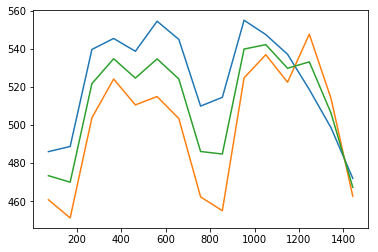

In [322]:
district = districts[i]
plt.plot(mdf[mdf.district == district]['dwell_x'])
plt.plot(mdf[mdf.district == district]['dwell_y'])
plt.plot(mdf[mdf.district == district]['dwell'])
i = (i + 1)%98